# Bioinformatics & Network Medicine - Final Project: Putative disease gene identification and drug repurposing for Renal cell carcinoma

- Name: Arman
- Surname: Feili
- Matricola: 2101835
- Email: feili.2101835@studenti.uniroma1.it

## Databases that are used in this project:

- **DISEASES**: (Gene-Disease Associations):
    - Provides the curated **Gene-Disease Association (GDA)** dataset for Renal Cell Carcinoma.
    - [https://diseases.jensenlab.org](https://diseases.jensenlab.org)  
    
- **BioGRID**: (Protein-Protein Interactions):  
   - Source of the **Protein-Protein Interaction (PPI)** data used to build the RCC-specific interactome.
   - [https://thebiogrid.org](https://thebiogrid.org)

- **DGIdb** (Drug-Gene Interaction Database)  
   - Contains **drug-gene interaction** information, used to identify and rank approved drugs targeting the top putative RCC genes.
   - [https://www.dgidb.org](https://www.dgidb.org)  

- **Enrichr** (Gene List Enrichment)  
   - Performed **gene enrichment analysis** on known and newly predicted RCC genes across multiple functional/pathway libraries.
   - [https://maayanlab.cloud/Enrichr](https://maayanlab.cloud/Enrichr)  

- **Gene Ontology (GO)**  
   - Accessed via Enrichr to evaluate overrepresented biological processes, molecular functions, and cellular components.
   - [http://geneontology.org](http://geneontology.org)  

- **Reactome**  
   - Accessed via Enrichr to identify enriched **pathways** shared by known and predicted RCC genes.
   - [https://reactome.org](https://reactome.org)  

- **KEGG** (Kyoto Encyclopedia of Genes and Genomes)  
   - Accessed via Enrichr to determine **KEGG pathways** overrepresented in the known and predicted gene sets.
   - [https://www.genome.jp/kegg](https://www.genome.jp/kegg)  

- **ClinicalTrials.gov**  
   - Checked existing and ongoing **clinical trials** for the top repurposed drugs (e.g., Cisplatin, Dexamethasone) in the context of Renal Cell Carcinoma.
   - [https://clinicaltrials.gov](https://clinicaltrials.gov)  

## Imports

### Process:
- We imported various Python libraries like os, pandas, numpy, shutil, networkx, etc., to handle file operations, data processing, graph creation, visualization, and statistical analysis.
- Used drive.mount() to connect and access files stored on Google Drive.
- Specified the main project workspace path in the variable root_path.
- Set paths for a curated Gene-Disease Association (GDA) dataset and a Protein-Protein Interaction (PPI) dataset.
- Changed the working directory to the project root directory to ensure relative paths work seamlessly for file access.
- Provided the exact file paths for accessing and processing two key datasets: `DISEASES_Summary_GDA_CURATED_C0007134.tsv` and `BIOGRID-ALL-4.4.240.tab3.txt`.

In [ ]:
import os
import pandas as pd
import numpy as np
import shutil
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import random
import math
import time
import requests
from google.colab import drive
from IPython.display import HTML
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import hypergeom

# Step 1: Initialize Google Drive and Paths

# Mount Google Drive to access files stored remotely
drive.mount('/content/gdrive')

# Define the main path to the project workspace on Google Drive
root_path = '/content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/'

# Change the current working directory to the project root path
%cd $root_path

# Define the path to the curated GDA (Gene-Disease Association) dataset
gda_dataset_path = root_path + 'datasets/DISEASES_Summary_GDA_CURATED_C0007134.tsv'

# Define the path to the raw PPI (Protein-Protein Interaction) dataset from BioGRID
ppi_dataset_path = root_path + 'datasets/BIOGRID-ALL-4.4.240.tab3.txt'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project


## Part 1 - PPI and GDA data gathering and interactome reconstruction

### Goal:
The goal of this task is to reconstruct a disease-specific interactome using gene-disease associations (GDAs) and protein-protein interaction (PPI) data. The aim is to identify the largest connected component (LCC) of the interactome (the whole set of molecular interactions in a cell), filter relevant human physical interactions, and compute key network metrics (e.g., degree, betweenness, centrality) for disease-related genes.  

- **GDA Dataset**: Load curated gene-disease associations to identify disease-specific genes.
- **PPI Dataset**: Filter the BioGRID dataset to include:  
   - Only human interactions (organism ID = 9606).  
   - Physical interactions with direct experimental evidence.  
   - Unique interactions, removing duplicates and self-loops.  

### The process we went through:
- Got the current working directory to set up the project environment.  
- Created a directory to store results if it didn’t already exist.  
- Prepared paths for caching results and initialized a dictionary to store all variables.  
- Checked if a cache file exists; if yes, loaded precomputed data to avoid redundant computations.  
- Stored and reused data like gene lists, graph metrics, and dataset paths from the cache.  
- If no cache was found, loaded GDA and PPI datasets to start fresh computations.  
- Filtered PPI data for human-specific, physical interactions and removed duplicates and self-loops.  
- Built a graph for RCC-related interactions and extracted its largest connected component (LCC).  
- Computed basic graph properties like node and edge counts for the LCC.  
- Calculated network metrics for genes in the LCC, including degree, betweenness, eigenvector, and closeness centrality.  
- Stored the metrics in a table and ranked the top 50 genes by degree.  
- Created a scatterplot of node degree vs. betweenness centrality and saved it.  
- Cached computed results for reuse in future runs.  
- Displayed the metrics table and completed the script.  

In [ ]:
# Get the current working directory (should be the project root)
root_path = os.getcwd()

# Define the directory where results will be stored
results_dir = os.path.join(root_path, 'results')

# Create the results directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

# Define a path for caching computed results
cache_file = os.path.join(results_dir, 'cached_results.pkl')

# Initialize a dictionary to store all variables
data_to_store = {}

# Store initial variables in the data_to_store dictionary
data_to_store['root_path'] = root_path
data_to_store['results_dir'] = results_dir
data_to_store['cache_file'] = cache_file

# Check if cached results exist
if os.path.exists(cache_file):                          # Verify if the cache file is present in the specified path.
    # If cache file is found, load precomputed data
    print("Loading precomputed data from cache...")     # Notify that cached data is being loaded.
    with open(cache_file, 'rb') as f:                   # Open the cache file in binary read mode.
        data = pickle.load(f)                           # Deserialize and load the cached data into the `data` variable.

    # Retrieve variables from the cached data
    rcc_genes = data['rcc_genes']                       # List of RCC genes.
    num_rcc_genes = data['num_rcc_genes']               # Count of RCC genes.
    num_genes_in_interactome = data['num_genes_in_interactome']  # Count of genes in the interactome.
    lcc_num_nodes = data['lcc_num_nodes']               # Number of nodes in the largest connected component (LCC).
    lcc_num_edges = data['lcc_num_edges']               # Number of edges in the LCC.
    metrics_df = data['metrics_df']                     # DataFrame containing computed network metrics.
    degree_dict = data['degree_dict']                   # Dictionary mapping genes to their degree centrality.
    betweenness_dict = data['betweenness_dict']         # Dictionary mapping genes to their betweenness centrality.
    lcc_graph = data['lcc_graph']                       # Graph object representing the LCC.
    gda_data = data['gda_data']                         # GDA (Gene-Disease Association) dataset.
    ppi_data = data['ppi_data']                         # Raw Protein-Protein Interaction (PPI) dataset.
    human_ppi_data = data['human_ppi_data']             # PPI data filtered for human-specific interactions.
    physical_ppi_data = data['physical_ppi_data']       # PPI data filtered for physical interactions.
    rcc_ppi = data['rcc_ppi']                           # PPI data specifically involving RCC genes.
    gda_dataset_path = data['gda_dataset_path']         # Path to the GDA dataset file.
    ppi_dataset_path = data['ppi_dataset_path']         # Path to the PPI dataset file.
    table2_path = data['table2_path']                   # Path to the saved metrics table (e.g., Table 2).
    scatterplot_path = data['scatterplot_path']         # Path to the saved scatterplot.

    # Store loaded variables into data_to_store for completeness
    data_to_store['rcc_genes'] = rcc_genes              # List of RCC genes for future use.
    data_to_store['num_rcc_genes'] = num_rcc_genes      # Count of RCC genes.
    data_to_store['num_genes_in_interactome'] = num_genes_in_interactome  # Count of genes in the interactome.
    data_to_store['lcc_num_nodes'] = lcc_num_nodes      # Number of nodes in the LCC.
    data_to_store['lcc_num_edges'] = lcc_num_edges      # Number of edges in the LCC.
    data_to_store['metrics_df'] = metrics_df            # DataFrame with network metrics.
    data_to_store['degree_dict'] = degree_dict          # Dictionary of degree centrality.
    data_to_store['betweenness_dict'] = betweenness_dict  # Dictionary of betweenness centrality.

    # print(data)
else:
    # If no cache is found, perform the computations
    print("Cache not found. Running computations...")

    # Store these paths
    data_to_store['gda_dataset_path'] = gda_dataset_path
    data_to_store['ppi_dataset_path'] = ppi_dataset_path

    # Load the GDA data
    gda_data = pd.read_csv(gda_dataset_path, sep='\t')
    # Extract unique RCC genes
    rcc_genes = gda_data['Gene'].unique()
    # Count the number of RCC genes
    num_rcc_genes = len(rcc_genes)

    # Load the PPI data
    ppi_data = pd.read_csv(ppi_dataset_path, sep='\t', low_memory=False)

    # Filter the PPI data for human-specific (organism 9606), physical interactions
    human_ppi_data = ppi_data[
        (ppi_data['Organism ID Interactor A'] == 9606) &
        (ppi_data['Organism ID Interactor B'] == 9606)
    ]
    physical_ppi_data = human_ppi_data[human_ppi_data['Experimental System Type'] == 'physical']

    # Remove duplicate interactions
    physical_ppi_data = physical_ppi_data.drop_duplicates(
        subset=['Official Symbol Interactor A', 'Official Symbol Interactor B']
    )
    # Remove self loops (where A == B)
    physical_ppi_data = physical_ppi_data[
        physical_ppi_data['Official Symbol Interactor A'] != physical_ppi_data['Official Symbol Interactor B']
    ]

    # Subset PPI data to include only interactions that involve at least one RCC gene
    rcc_ppi = physical_ppi_data[
        (physical_ppi_data['Official Symbol Interactor A'].isin(rcc_genes)) |
        (physical_ppi_data['Official Symbol Interactor B'].isin(rcc_genes))
    ]

    # Create a graph from the RCC-related PPI edges
    rcc_graph = nx.from_pandas_edgelist(rcc_ppi,
                                        source='Official Symbol Interactor A',
                                        target='Official Symbol Interactor B')

    # Extract the largest connected component (LCC) of the RCC graph
    lcc = max(nx.connected_components(rcc_graph), key=len)
    lcc_graph = rcc_graph.subgraph(lcc)

    # Count nodes and edges in the LCC
    lcc_num_nodes = len(lcc_graph.nodes())
    lcc_num_edges = len(lcc_graph.edges())

    # Count how many RCC genes are present in the interactome
    num_genes_in_interactome = len(set(rcc_genes) & set(physical_ppi_data['Official Symbol Interactor A'].unique()))

    # Print LCC size info
    print(f"LCC contains {lcc_num_nodes} nodes and {lcc_num_edges} edges.")

    # Compute various network metrics on the LCC
    degree_dict = dict(nx.degree(lcc_graph))
    # Compute betweenness centrality (sampling k nodes if large)
    betweenness_dict = nx.betweenness_centrality(lcc_graph, normalized=True, k=min(100, len(lcc_graph)))
    # Compute eigenvector centrality
    eigenvector_dict = nx.eigenvector_centrality(lcc_graph, max_iter=500)

    # Determine how many nodes to sample for closeness calculation
    sample_size = min(lcc_num_nodes, lcc_num_nodes)  # This effectively is lcc_num_nodes
    # Randomly sample nodes (or all of them if sample_size == lcc_num_nodes)
    sampled_nodes = random.sample(list(lcc_graph.nodes()), sample_size)

    # Dictionary to hold closeness values
    closeness_dict = {}
    # Compute closeness centrality by shortest paths for sampled nodes
    for i, node in enumerate(sampled_nodes):
        if i % 100 == 0:
            print(f"Computing closeness centrality: {i}/{sample_size} nodes processed")
        sp = nx.single_source_shortest_path_length(lcc_graph, node)
        totsp = sum(sp.values())
        closeness_dict[node] = (len(sp)-1)/totsp if totsp > 0.0 and len(lcc_graph) > 1 else 0.0

    # Compute an average closeness for non-sampled nodes (if any)
    avg_closeness = sum(closeness_dict.values())/len(closeness_dict)
    # Assign average closeness to any node not in closeness_dict (shouldn't happen if we sampled all)
    for node in lcc_graph.nodes():
        if node not in closeness_dict:
            closeness_dict[node] = avg_closeness

    # Prepare a list of dictionaries for metrics per gene to convert into a DataFrame
    metrics_data = []
    for gene, degree in degree_dict.items():
        bet = betweenness_dict.get(gene, 0)
        eig = eigenvector_dict.get(gene, 0)
        clo = closeness_dict.get(gene, 0)
        ratio = bet / degree if degree > 0 else 0
        metrics_data.append({
            "Gene name": gene,
            "Degree": degree,
            "Betweenness": bet,
            "Eigenvector centrality": eig,
            "Closeness centrality": clo,
            "ratio Betw./Degree": ratio
        })

    # Convert metrics data into a DataFrame
    metrics_df = pd.DataFrame(metrics_data)
    # Sort by Degree in descending order
    metrics_df = metrics_df.sort_values(by="Degree", ascending=False).reset_index(drop=True)
    # Set a ranking column
    metrics_df.index += 1
    metrics_df["Ranking"] = metrics_df.index

    # Extract top 50 genes by degree
    top_50_metrics_df = metrics_df.head(50)
    # Define a path to save the metrics table
    table2_path = os.path.join(results_dir, 'table2_lcc_metrics.csv')
    top_50_metrics_df.to_csv(table2_path, index=False)

    # Plot scatterplot of node degree vs. betweenness
    degrees = [degree_dict[node] for node in lcc_graph.nodes()]
    betweenness = [betweenness_dict[node] for node in lcc_graph.nodes()]
    scatterplot_path = os.path.join(results_dir, 'node_degree_vs_betweenness.png')
    plt.figure(figsize=(10, 6))
    plt.scatter(degrees, betweenness, alpha=0.6, edgecolor='k', marker='o')
    plt.title("Scatterplot of Node Degree vs. Betweenness Centrality")
    plt.xlabel("Node Degree")
    plt.ylabel("Betweenness Centrality")
    plt.grid(alpha=0.3)
    plt.savefig(scatterplot_path)
    plt.close()

    # Store all computed variables into data_to_store
    data_to_store['gda_data'] = gda_data
    data_to_store['rcc_genes'] = rcc_genes
    data_to_store['num_rcc_genes'] = num_rcc_genes
    data_to_store['ppi_data'] = ppi_data
    data_to_store['human_ppi_data'] = human_ppi_data
    data_to_store['physical_ppi_data'] = physical_ppi_data
    data_to_store['rcc_ppi'] = rcc_ppi
    data_to_store['rcc_graph'] = rcc_graph
    data_to_store['lcc'] = lcc
    data_to_store['lcc_graph'] = lcc_graph
    data_to_store['lcc_num_nodes'] = lcc_num_nodes
    data_to_store['lcc_num_edges'] = lcc_num_edges
    data_to_store['num_genes_in_interactome'] = num_genes_in_interactome
    data_to_store['degree_dict'] = degree_dict
    data_to_store['betweenness_dict'] = betweenness_dict
    data_to_store['eigenvector_dict'] = eigenvector_dict
    data_to_store['sample_size'] = sample_size
    data_to_store['sampled_nodes'] = sampled_nodes
    data_to_store['closeness_dict'] = closeness_dict
    data_to_store['avg_closeness'] = avg_closeness
    data_to_store['metrics_data'] = metrics_data
    data_to_store['metrics_df'] = metrics_df
    data_to_store['top_50_metrics_df'] = top_50_metrics_df
    data_to_store['table2_path'] = table2_path
    data_to_store['scatterplot_path'] = scatterplot_path

    # Cache results for future runs
    with open(cache_file, 'wb') as f:
        pickle.dump(data_to_store, f)
    print("Data cached for future runs.")

# Print all stored data keys and values
print("\nAll Stored Data:")
for key, value in data_to_store.items():
    print(f"{key}: {value}")

print("\nDone.")

# =============================================
# Show results in tables or plots (final section)
# =============================================

# Display the rows of metrics_df as a table
print("\nThe metrics_df:")
display(data_to_store['metrics_df'])

Loading precomputed data from cache...
Data loaded from cache. Skipping long computations.

All Stored Data:
root_path: /content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project
results_dir: /content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results
cache_file: /content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results/cached_results.pkl
rcc_genes: ['VHL' 'PBRM1' 'FLCN' 'TFE3' 'MET' 'ERBB2' 'BAP1' 'TP53' 'MTOR' 'PTEN'
 'IL2' 'SDHB' 'EPAS1' 'IL6' 'TNF' 'STAT3' 'HNF1A' 'GSTT1' 'GSTM1' 'TSC1'
 'PIK3CA' 'OGG1' 'CCND1' 'BIRC5' 'FLT1' 'CA9' 'FAS' 'TGFB1' 'CTLA4' 'FHIT'
 'ADIPOQ' 'TGM2' 'MITF' 'GJB1' 'ALK' 'GSTP1' 'TNFSF10' 'ABCG2' 'EGLN3'
 'CSF1R' 'HAVCR2' 'CDH1' 'XRCC1' 'RNF139' 'BCL2' 'PDGFRB' 'CYP1A1' 'KRT7'
 'SETD2' 'IL4R' 'PAK1' 'RELA' 'PTGS2' 'APC' 'HNF1B' 'CDKN2A' 'MAPK1'
 'RASSF1' 'ABCB1' 'KIT' 'KEAP1' 'IL6R' 'BSG' 'HLA-DRB1' 'ARNT' 'LTF'
 'MMP1' 'CDK2' 'TNFRSF10A' 'TP73' 'PSMB9' 'MAP2K1' 'EGLN2' 'THRB' 'FTO'
 'COMT' 'MMP3' 'PRCC' 'BIRC7' 'DAPK1' 'ALOX5' 'PVALB' 'ACY1' 'ELOC'

,Gene name,Degree,Betweenness,Eigenvector centrality,Closeness centrality,ratio Betw./Degree,Ranking
1,TP53,2180,0.202423,0.352125,0.498386,0.000093,1
2,EGLN3,1291,0.105281,0.170427,0.436253,0.000082,2
3,BAP1,1278,0.102793,0.234356,0.439168,0.000080,3
4,HSPD1,985,0.110546,0.159718,0.436507,0.000112,4
5,NR3C1,943,0.071314,0.116472,0.430214,0.000076,5
...,...,...,...,...,...,...,...
9725,SKA1,1,0.000000,0.002344,0.303753,0.000000,9725
9726,CNOT6,1,0.000000,0.002344,0.303753,0.000000,9726
9727,IFT22,1,0.000000,0.002344,0.303753,0.000000,9727
9728,FEZ2,1,0.000000,0.002344,0.303753,0.000000,9728


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


#### Interactome Construction  
- **Extract** interactions involving at least one **disease-related gene from the GDA** dataset.  
- **Build** a network **graph with the filtered PPI** data using NetworkX.  
- Identify the **largest connected component (LCC) to ensure maximum network connectivity.**

#### Network Metrics  
- **Degree centrality** measures the number of direct connections a node (gene) has in the network.
  - High degree centrality indicates a hub in the network—nodes with many connections, often critical for maintaining network integrity.
  - In this prroject, TP53 had the highest degree (2180), meaning it is highly connected and possibly plays a central role in RCC progression.

- **Betweenness centrality** measures how often a node acts as a bridge along the shortest paths between other nodes in the network.
  - High betweenness centrality indicates that a node is a key mediator or connector in the network.
  - TP53 also had a high betweenness value (0.232813), suggesting its regulatory role in connecting different parts of the network.

- **Eigenvector centrality** measures the influence of a node based not only on its connections but also on the importance of the nodes it is connected to.
  - Nodes connected to highly influential nodes receive higher eigenvector centrality scores.
  - In this project, TP53 also had a high eigenvector centrality (0.352125), showing its global influence in the network.

- **Closeness centrality** measures how close a node is to all other nodes in the network, based on the shortest paths.
  - High closeness centrality means a node can quickly interact with or influence many other nodes in the network.
  - Genes like HSPD1 and NR3C1 showed notable closeness centrality in this study, indicating their efficient communication roles.

- **Betweenness-to-Degree Ratio** is the ratio of a node's betweenness centrality to its degree centrality. It measures how efficiently a node leverages its connections to act as a bridge in the network.
  - A high ratio indicates a node is strategically positioned in the network despite having fewer direct connections.
  - TP53 had a low ratio (0.000107), suggesting its high degree centrality is the primary driver of its importance, rather than being an efficient bridge.


### Explanation of Stored Data  

- **Gene-Disease Association (GDA) Data**
  - **`gda_data`**: DataFrame containing gene-disease associations loaded from the GDA dataset. Focused on genes associated with Renal Cell Carcinoma (RCC).  
  - **`rcc_genes`**: Unique list of RCC-associated genes extracted from the GDA dataset.  
  - **`num_rcc_genes`**: Total number of RCC-related genes identified.  

- **Protein-Protein Interaction (PPI) Data**
  - **`ppi_data`**: DataFrame containing raw PPI data loaded from the BioGRID dataset.  
  - **`human_ppi_data`**: Filtered PPI data for human-specific interactions (organism ID = 9606).  
  - **`physical_ppi_data`**: Further filtered dataset containing only physical interactions.  
  - **`rcc_ppi`**: Subset of PPI data that includes interactions involving at least one RCC-related gene.  

- **Largest Connected Component (LCC)**
  - **`rcc_graph`**: NetworkX graph of the RCC-specific interactome built from `rcc_ppi`.  
  - **`lcc`**: The largest connected component (LCC) of the `rcc_graph`, representing the most interconnected subgraph.  
  - **`lcc_graph`**: NetworkX graph of the LCC.  
  - **`lcc_num_nodes`**: Number of nodes (genes) in the LCC.  
  - **`lcc_num_edges`**: Number of edges (interactions) in the LCC.  
  - **`num_genes_in_interactome`**: Count of RCC-related genes present in the interactome.  

- **Network Metrics**
  - **`degree_dict`**: Dictionary of degree values (connections) for each gene in the LCC.  
  - **`betweenness_dict`**: Betweenness centrality scores for each gene.  
  - **`eigenvector_dict`**: Eigenvector centrality scores for each gene.  
  - **`closeness_dict`**: Closeness centrality scores for each gene.  
  - **`avg_closeness`**: Average closeness centrality of all genes in the LCC.  
  - **`metrics_data`**: List of dictionaries containing network metrics for each node.  
  - **`metrics_df`**: DataFrame of all network metrics for the LCC.  
  - **`top_50_metrics_df`**: Subset of `metrics_df` showing the top 50 genes by degree.  

### Results:

- We successfully loaded precomputed data from cache to save time.  
- Set up and stored paths for the project root, results directory, and cache file.  
- Identified 179 RCC genes from the Gene-Disease Association (GDA) dataset.  
- Confirmed 169 RCC genes are part of the protein-protein interaction (PPI) network.  
- The largest connected component (LCC) of the RCC interaction graph includes 9,729 nodes and 32,164 edges.  
- Calculated network metrics for all nodes, including degree, betweenness, eigenvector, and closeness centrality.  
- Created a ranked table of 9,729 genes based on their metrics, sorted by degree.  
- Top-ranked gene is TP53 with the highest degree, followed by EGLN3 and BAP1.  
- The table includes key metrics like the ratio of betweenness to degree for further analysis.  
- Demonstrated efficient reuse of cached data, avoiding repetitive computations and ensuring consistency.


## part 2 - Comparative analysis of the disease genes identification algorithms

### Goal:

The goal of the second task is to evaluate algorithms for identifying disease-related genes by testing three approaches: **DIAMOnD**, **DiaBLE**, and **Diffusion**. The algorithms are assessed based on their ability to rank genes associated with known diseases. Performance is measured using **precision**, **recall**, **F1-score**, and **accuracy** across different thresholds.

### The process we went through:

- We initialized a dictionary to store all variables for easy access and reuse.  
- A fixed random seed ensures consistent results across runs when shuffling data or generating random numbers.  
- The `calculate_metrics` function computes **precision**, **recall**, **F1-score**, and **accuracy** at different thresholds, which define the top-ranked genes being evaluated.
- Cross-Validation Process:
    - A **5-fold cross-validation** splits the dataset into training and test sets.  
    - Each algorithm is trained on the training set and evaluated on the test set, using known genes and their graph structure.
- Algorithms tested:
   - **DIAMOnD**: Identifies genes iteratively using hypergeometric p-value enrichment.  
   - **DiaBLE**: A modified DIAMOnD algorithm restricted to top-degree nodes in the network.  
   - **Diffusion**: Implements a Random Walk with Restart (RWR) to rank genes based on their relationship to seed genes.- Evaluated the performance of these algorithms through k-fold cross-validation using known genes.
- Parameter Tuning:
   - Each algorithm is tested with multiple configurations, including iterations (`max_steps`), thresholds (`pval_threshold`), restart probabilities, and ensemble runs.  
   - Results for all configurations are cached to avoid redundant calculations.
- Stored evaluation thresholds and created a summary table comparing algorithms' precision, recall, F1-score, and accuracy across these thresholds.  
- Generated plots for visualizing algorithm performance across different thresholds for metrics like precision, recall, F1-score, and accuracy.  
- Saved the summary table and plots to disk for future reference.  
- Displayed the top rows of the summary table for easy review of the results.

Loading previously computed cross-validation fine-tuning results from cache...
Algorithm fine-tuning comparison summary saved to: /content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results/algorithm_comparison_fine_tuning_summary.csv


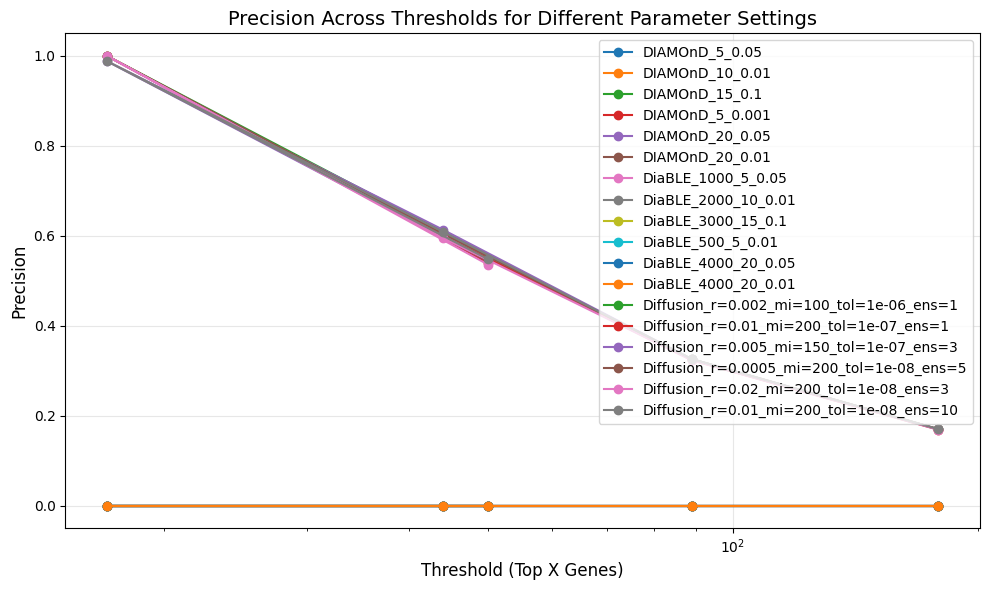

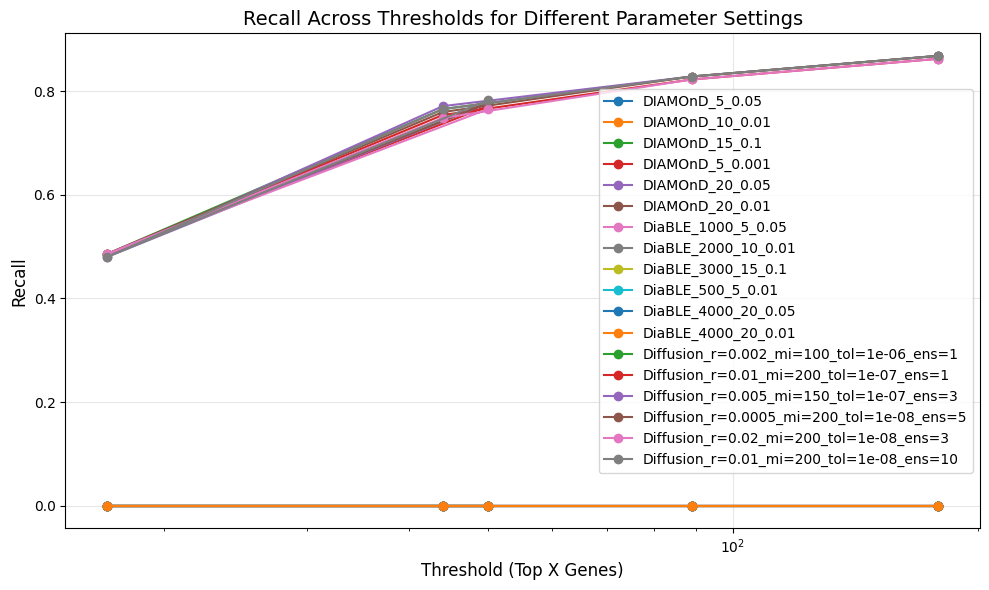

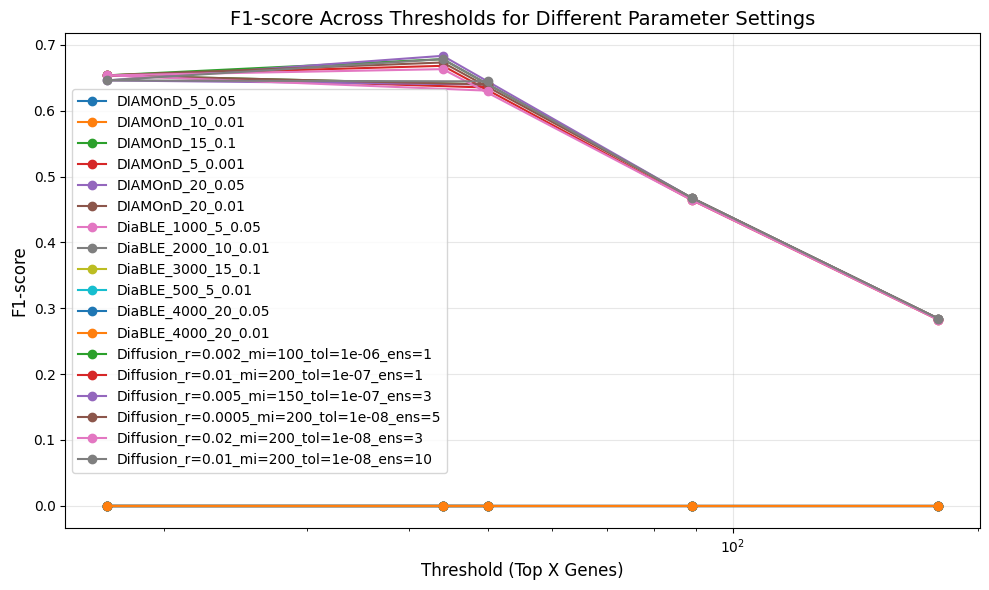

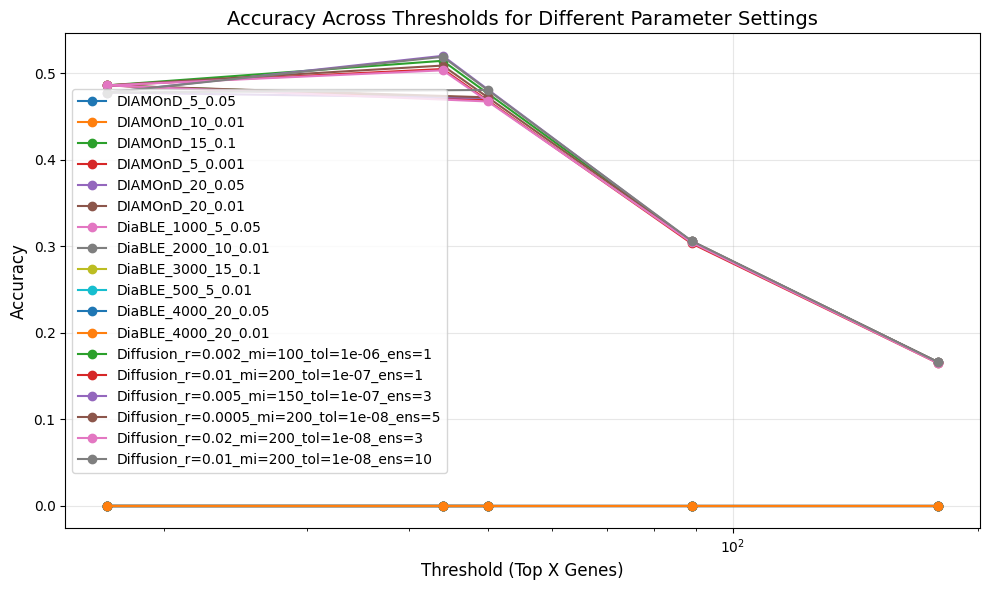


All Stored Data:
RANDOM_SEED: 42
diamond_params: [{'max_steps': 5, 'pval_threshold': 0.05}, {'max_steps': 10, 'pval_threshold': 0.01}, {'max_steps': 15, 'pval_threshold': 0.1}, {'max_steps': 5, 'pval_threshold': 0.001}, {'max_steps': 20, 'pval_threshold': 0.05}, {'max_steps': 20, 'pval_threshold': 0.01}]
diable_params: [{'universe_size': 1000, 'max_steps': 5, 'pval_threshold': 0.05}, {'universe_size': 2000, 'max_steps': 10, 'pval_threshold': 0.01}, {'universe_size': 3000, 'max_steps': 15, 'pval_threshold': 0.1}, {'universe_size': 500, 'max_steps': 5, 'pval_threshold': 0.01}, {'universe_size': 4000, 'max_steps': 20, 'pval_threshold': 0.05}, {'universe_size': 4000, 'max_steps': 20, 'pval_threshold': 0.01}]
diffusion_params: [{'restart_prob': 0.002, 'max_iter': 100, 'tol': 1e-06}, {'restart_prob': 0.01, 'max_iter': 200, 'tol': 1e-07}, {'restart_prob': 0.005, 'max_iter': 150, 'tol': 1e-07, 'ensemble_runs': 3}, {'restart_prob': 0.0005, 'max_iter': 200, 'tol': 1e-08, 'ensemble_runs': 5}, {'

,Algorithm,Precision (Top 50),Recall (Top 50),F1-score (Top 50),Accuracy (Top 50),Precision (Top 17),Recall (Top 17),F1-score (Top 17),Accuracy (Top 17),Precision (Top 44),...,F1-score (Top 44),Accuracy (Top 44),Precision (Top 89),Recall (Top 89),F1-score (Top 89),Accuracy (Top 89),Precision (Top 179),Recall (Top 179),F1-score (Top 179),Accuracy (Top 179)
0,DIAMOnD_5_0.05,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,DIAMOnD_10_0.01,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,DIAMOnD_15_0.1,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,DIAMOnD_5_0.001,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,DIAMOnD_20_0.05,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,DIAMOnD_20_0.01,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,DiaBLE_1000_5_0.05,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,DiaBLE_2000_10_0.01,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,DiaBLE_3000_15_0.1,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,DiaBLE_500_5_0.01,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Initialize a dictionary to store all variables
data_to_store = {}

# Fix the random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Store random seed
data_to_store['RANDOM_SEED'] = RANDOM_SEED

def calculate_metrics(predicted_genes, true_genes, thresholds):
    """
    Calculate accuracy, precision, recall, and F1-score at given thresholds.

    This function evaluates the performance of predicted gene lists at multiple threshold levels.
    For each threshold, it compares the top predicted genes with the set of true genes and computes
    key performance metrics:
    - Precision: How many of the predicted genes are true positives.
    - Recall: How many of the true genes are identified in the predicted list.
    - F1-score: The harmonic mean of precision and recall, balancing the two.
    - Accuracy: The proportion of true positives out of all evaluated predictions.
    """
    results = []  # List to store metrics results for each threshold
    # Loop over each threshold to compute metrics at different levels
    for threshold in thresholds:
        # Select top predicted genes up to the current threshold
        top_genes = predicted_genes[:threshold]

        # Determine true positives: genes that are both in top_genes and true_genes
        true_positive = set(top_genes) & set(true_genes)
        # Determine false positives: genes predicted in top_genes but not in true_genes
        false_positive = set(top_genes) - set(true_genes)
        # Determine false negatives: genes in true_genes but not in top_genes
        false_negative = set(true_genes) - set(top_genes)

        # Compute precision: TP / (TP + FP)
        precision = len(true_positive) / len(top_genes) if len(top_genes) > 0 else 0
        # Compute recall: TP / (TP + FN)
        recall = len(true_positive) / len(true_genes) if len(true_genes) > 0 else 0
        # Compute F1-score: harmonic mean of precision and recall
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        # Compute accuracy: TP / (TP + FP + FN)
        accuracy = (len(true_positive)) / (len(true_positive) + len(false_positive) + len(false_negative)) \
                   if (len(true_positive) + len(false_positive) + len(false_negative)) > 0 else 0

        # Append all computed metrics for this threshold into the results list
        results.append({
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Accuracy': accuracy
        })

    # Convert the list of metrics dictionaries into a DataFrame for easy viewing
    return pd.DataFrame(results)


def cross_validate(algorithm, lcc_graph, known_genes, k=5):
    """
    Perform k-fold cross-validation for the given algorithm.

    This function evaluates the performance of a gene prioritization algorithm
    using k-fold cross-validation. The dataset of known genes is divided into k subsets
    (folds). Each fold is used as a test set exactly once, while the remaining folds
    are combined to form the training set. The algorithm is run on the training set,
    and its predictions are evaluated against the test set using performance metrics
    such as precision, recall, F1-score, and accuracy. The results are averaged across
    all folds to assess the algorithm's overall performance.

    Parameters:
    - algorithm: A gene prioritization algorithm to evaluate.
    - lcc_graph: The largest connected component of a network, used as the input graph.
    - known_genes: A list of genes known to be associated with a specific condition.
    - k: The number of folds to divide the data into (default is 5).
    """
    # Create a copy of known_genes to shuffle without affecting the original list
    shuffled_genes = known_genes[:]
    # Randomly shuffle the known genes to ensure random splitting into folds
    random.shuffle(shuffled_genes)
    # Determine the size of each fold
    fold_size = len(shuffled_genes) // k
    # List to store metrics DataFrames for each fold
    metrics_per_fold = []

    # Iterate through each fold
    for i in range(k):
        print(f"Processing fold {i+1}/{k} for cross-validation...")
        # The test set is the i-th slice of shuffled_genes
        test_set = set(shuffled_genes[i * fold_size:(i + 1) * fold_size])
        # The training set is all remaining genes not in the test set
        train_set = set(shuffled_genes) - test_set

        # Apply the given algorithm using the training set as seed genes
        predicted_genes = algorithm(lcc_graph, train_set)

        # Filter out training genes from predictions to avoid bias
        ranked_predictions = [gene for gene in predicted_genes if gene not in train_set]

        # Define different thresholds for evaluation
        thresholds = [
            50,
            int(len(known_genes)*0.1),
            int(len(known_genes)*0.25),
            int(len(known_genes)*0.5),
            len(known_genes)
        ]

        # Calculate metrics at the defined thresholds for this fold
        metrics_df = calculate_metrics(ranked_predictions, test_set, thresholds)
        # Store the metrics DataFrame for this fold
        metrics_per_fold.append(metrics_df)

    # Concatenate all folds' metrics and compute their mean grouped by threshold
    return pd.concat(metrics_per_fold).groupby('Threshold').mean()


def hypergeometric_pvalue(k, K, n, N):
    """
    This function calculates the hypergeometric p-value using the survival function (sf).
    The hypergeometric p-value represents the probability of observing at least 'k' successes
    in a random sample of size 'n' drawn without replacement from a population of size 'N',
    where the population contains 'K' successes.

    # k: The number of successes observed in the drawn sample.
    # K: The total number of successes available in the entire population.
    # n: The size of the sample drawn from the population.
    # N: The total size of the population.
    """
    return hypergeom.sf(k - 1, N, K, n)  # Returns the probability of observing at least 'k' successes.


def rwr_diffusion_algorithm(graph, seed_genes, restart_prob=0.3, max_iter=100, tol=1e-6, ensemble_runs=1):
    """
    Random Walk with Restart (RWR) algorithm for gene prioritization.

    This algorithm simulates a random walk on the graph, where the walker starts
    from a set of seed nodes (known genes) and has a probability of "restarting"
    at the seed nodes during each step. The goal is to prioritize nodes (genes)
    based on their connectivity to the seed nodes. The method incorporates restart
    probabilities, ensures convergence through iterative updates, and handles numerical
    robustness by averaging results from multiple runs with slightly varied parameters.

    Parameters:
    - graph: The input network represented as a graph (e.g., a protein-protein interaction graph).
    - seed_genes: A list of seed nodes (genes) known to be associated with a condition.
    - restart_prob: Probability of restarting the walk at the seed nodes (default is 0.3).
    - max_iter: Maximum number of iterations to perform per run (default is 100).
    - tol: Convergence tolerance, determining when the probability vector stops changing significantly (default is 1e-6).
    - ensemble_runs: Number of independent runs to average for robustness (default is 1).
    """
    # Extract the list of nodes from the graph
    nodes = list(graph.nodes())
    # Map each node to its index for matrix operations
    node_index = {node: i for i, node in enumerate(nodes)}
    # Number of nodes in the graph
    n = len(nodes)

    # Initialize a column-stochastic adjacency matrix (n x n)
    adjacency = np.zeros((n, n), dtype=float)
    degrees = dict(graph.degree())

    # Fill the adjacency matrix with transition probabilities
    for node in nodes:
        idx = node_index[node]
        neighbors = list(graph.neighbors(node))
        deg = len(neighbors)
        if deg > 0:
            # Each neighbor receives equal probability mass 1/deg from this node
            for nbr in neighbors:
                adjacency[node_index[nbr], idx] = 1.0 / deg

    # Create a starting probability vector p0
    p0 = np.zeros(n)
    # Identify seed nodes that are present in the graph
    seed_nodes = [node_index[g] for g in seed_genes if g in node_index]

    # Weighted initialization: if we have seed nodes, distribute probabilities
    # according to their degrees; otherwise assign uniform probability
    if seed_nodes:
        total_degree = sum(degrees[nodes[i]] for i in seed_nodes)
        for sn in seed_nodes:
            p0[sn] = degrees[nodes[sn]] / total_degree
    else:
        p0[:] = 1.0 / n

    def single_run(rp):
        """
        Perform a single execution of the Random Walk with Restart (RWR) algorithm.

        This function simulates a single random walk across the graph to calculate
        the probability distribution of visiting each node starting from the seed nodes.
        At each step, the walker either continues along the graph edges or "restarts"
        back to the seed nodes with a probability defined by `rp` (restart probability).
        The process iteratively updates the probability distribution until convergence
        (measured by the change in probabilities falling below a tolerance `tol`) or
        a maximum number of iterations (`max_iter`) is reached.

        Parameters:
        - rp: Restart probability, determining how often the walker restarts from the seed nodes.

        Returns:
        - p: Final probability distribution vector over all nodes.
        """
        # Perform RWR for a single run with restart probability rp
        p = p0.copy()
        current_max_iter = max_iter
        iteration = 0
        # Iterate until convergence or we hit max_iter
        while iteration < current_max_iter:
            # Compute new probability distribution
            p_new = (1 - rp) * adjacency @ p + rp * p0
            # Measure how much it changed from the previous iteration
            diff = np.sum(np.abs(p_new - p))
            p = p_new
            iteration += 1
            # If convergence is reached, break
            if diff < tol:
                break
            # If not converged at max_iter, increase max_iter for another attempt
            if iteration == current_max_iter and diff > tol:
                current_max_iter += 50
        return p

    # Ensemble averaging: run multiple RWRs with slightly perturbed restart probabilities
    scores_sum = np.zeros(n)
    for run in range(ensemble_runs):
        # Slightly adjust restart probability for robustness
        rp_perturbed = restart_prob * (1 + 0.01 * (run - ensemble_runs // 2))
        # Accumulate the scores from each run
        scores_sum += single_run(rp_perturbed)

    # Final scores are the average of ensemble runs
    p_final = scores_sum / ensemble_runs

    # Rank genes by their final scores in descending order
    ranked_indices = np.argsort(-p_final)
    ranked_genes = [nodes[i] for i in ranked_indices]

    # Return the ranked gene list
    return ranked_genes


def diamond_algorithm_factory(max_steps=5, pval_threshold=0.05):
    """
    Factory to create a DIAMOnD algorithm with given parameters.

    This function generates a customized DIAMOnD (Disease Module Detection) algorithm based on
    the provided parameters. The DIAMOnD algorithm iteratively identifies and adds new candidate
    genes to a module of disease-associated genes by calculating the statistical enrichment of
    their neighbors in the current module. The enrichment is measured using a hypergeometric
    p-value, which determines the likelihood of observing the overlap between the neighbors of a
    candidate and the module by random chance. Genes with the most significant enrichment
    (lowest p-value) are added to the module.

    Parameters allow adaptive thresholding for p-value significance and early stopping if no
    significant improvements are observed. This algorithm is useful for predicting additional
    genes that might be associated with a given disease based on network connectivity.

    Parameters:
    - max_steps: Maximum number of iterations to add candidates to the module.
    - pval_threshold: Initial threshold for hypergeometric p-value significance.

    Returns:
    - diamond_algorithm: A function implementing the DIAMOnD algorithm with the specified parameters.

    """
    def diamond_algorithm(graph, seed_genes):
        # Initialize the module with given seed genes
        module = set(seed_genes)
        # Extract all nodes from the graph
        all_nodes = set(graph.nodes())
        # Total number of nodes
        N = len(all_nodes)
        # Precompute neighbors for each node to speed up calculations
        neighbors_dict = {node: set(graph.neighbors(node)) for node in all_nodes}
        # Precompute degrees for tie-breaking and scoring
        degrees = dict(graph.degree())

        # Current p-value threshold for candidate selection
        current_pval_threshold = pval_threshold
        # Track steps without improvement to stop early if no progress
        no_improvement_steps = 0
        # Keep track of the module size to detect improvements
        last_module_size = len(module)

        # Iterate for a fixed number of steps
        for step in range(max_steps):
            # Candidates are nodes not yet in the module
            candidates = all_nodes - module
            # List to store candidate p-values and their degrees
            pvals = []
            # Current size of the module
            K = len(module)
            # If module is empty, stop early (no enrichment possible)
            if K == 0:
                print("No module genes left, stopping DIAMOnD early.")
                break

            # Compute hypergeometric p-value for each candidate gene
            for c in candidates:
                neighbors = neighbors_dict[c]
                k = len(neighbors & module)  # Overlap with module genes
                n = len(neighbors)           # Number of neighbors
                if n == 0:
                    continue
                # Compute the hypergeometric p-value
                pval = hypergeometric_pvalue(k, K, n, N)
                pvals.append((c, pval, degrees[c]))

            # If no candidates found, relax the threshold to try again
            if not pvals:
                current_pval_threshold *= 1.2
                print("No candidates found, relaxing p-value threshold to:", current_pval_threshold)
                continue

            # Sort candidates by p-value ascending, and then by degree descending
            pvals.sort(key=lambda x: (x[1], -x[2]))
            best_candidate, best_pval, _ = pvals[0]

            # If the best candidate passes the threshold, add it to the module
            if best_pval < current_pval_threshold:
                module.add(best_candidate)
                # Check if the module size increased, else increment no_improvement steps
                if len(module) == last_module_size:
                    no_improvement_steps += 1
                else:
                    no_improvement_steps = 0
                    last_module_size = len(module)
                # If no improvement after multiple attempts, stop
                if no_improvement_steps > 2:
                    print("No improvement after multiple additions, stopping.")
                    break
            else:
                # If no candidate passes the threshold, stop here
                print(f"No candidate passes p-value threshold ({current_pval_threshold}) at step {step+1}, stopping.")
                break

        # After finishing the iteration, score the remaining candidates
        candidates = all_nodes - module
        final_scores = {}
        K = len(module)
        for c in candidates:
            neighbors = neighbors_dict[c]
            k = len(neighbors & module)
            n = len(neighbors)
            # If no neighbors, score is 0
            if n == 0:
                final_scores[c] = 0
            else:
                # Compute a score based on -log10 p-value
                pval = hypergeometric_pvalue(k, K, n, N)
                final_scores[c] = -np.log10(pval+1e-12)

        # Rank the remaining candidates by their final scores in descending order
        ranked_predictions = sorted(final_scores.keys(), key=lambda x: final_scores[x], reverse=True)
        return ranked_predictions

    return diamond_algorithm


def diable_algorithm_factory(universe_size=1000, max_steps=5, pval_threshold=0.05):
    """
    Factory to create a DiaBLE algorithm with given parameters.

    This function generates a DiaBLE (Disease Module Detection with Limited Universe) algorithm
    configured to work on a restricted universe of nodes. Unlike the DIAMOnD algorithm, DiaBLE
    narrows the search space to a subset of top-degree nodes, defined by the `universe_size`
    parameter. This restriction helps focus on the most influential nodes in the network,
    reducing computational complexity and prioritizing high-impact candidates.

    The algorithm iteratively identifies new candidate genes to expand a disease-associated
    module. It evaluates candidates based on the hypergeometric p-value of their connections
    to the current module. Adaptive p-value thresholding and early stopping are implemented
    to ensure efficient and meaningful results.

    Parameters:
    - universe_size: Number of top-degree nodes to include in the restricted universe.
    - max_steps: Maximum number of iterations to add candidates to the module.
    - pval_threshold: Initial threshold for hypergeometric p-value significance.

    Returns:
    - diable_algorithm: A function implementing the DiaBLE algorithm with the specified parameters.

    """
    def diable_algorithm(graph, seed_genes):
        # Precompute degrees for node selection and scoring
        degrees = dict(graph.degree())
        # Select top universe_size nodes by degree to form the universe
        top_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:universe_size]
        universe = set(top_nodes)

        # The initial module is the intersection of seed_genes and the chosen universe
        module = set(seed_genes) & universe
        # The set of all nodes in the restricted universe
        all_nodes = universe
        # Total number of nodes in the universe
        N = len(all_nodes)

        # Precompute neighbors restricted to the universe
        neighbors_dict = {node: set(graph.neighbors(node)) & universe for node in all_nodes}

        # Current p-value threshold for candidate selection
        current_pval_threshold = pval_threshold
        # Track steps without improvement to stop early if no progress
        no_improvement_steps = 0
        # Keep track of module size to detect improvements
        last_module_size = len(module)

        # Iterate for a fixed number of steps
        for step in range(max_steps):
            # Candidates are nodes in the universe not in the module
            candidates = all_nodes - module
            pvals = []
            K = len(module)
            # If module is empty, stop early
            if K == 0:
                print("DiaBLE: No module genes left, stopping early.")
                break

            # Compute hypergeometric p-value for each candidate within the universe
            for c in candidates:
                neighbors = neighbors_dict[c]
                k = len(neighbors & module)
                n = len(neighbors)
                if n == 0:
                    continue
                pval = hypergeometric_pvalue(k, K, n, N)
                pvals.append((c, pval, degrees[c]))

            # If no candidates found, relax threshold and retry
            if not pvals:
                current_pval_threshold *= 1.2
                print("DiaBLE: No candidates found, relaxing p-value threshold to:", current_pval_threshold)
                continue

            # Sort candidates by p-value ascending, then by degree descending
            pvals.sort(key=lambda x: (x[1], -x[2]))
            best_candidate, best_pval, _ = pvals[0]

            # If the best candidate passes the threshold, add it to the module
            if best_pval < current_pval_threshold:
                module.add(best_candidate)
                # Check if module size increased
                if len(module) == last_module_size:
                    no_improvement_steps += 1
                else:
                    no_improvement_steps = 0
                    last_module_size = len(module)
                # If no improvement after several steps, stop
                if no_improvement_steps > 2:
                    print("DiaBLE: No improvement after multiple additions, stopping.")
                    break
            else:
                # If no candidate passes the threshold, stop here
                print(f"DiaBLE: No candidate passes p-value threshold ({current_pval_threshold}) at step {step+1}, stopping.")
                break

        # After finishing the iteration, score remaining candidates in the universe
        candidates = all_nodes - module
        final_scores = {}
        K = len(module)
        for c in candidates:
            neighbors = neighbors_dict[c]
            k = len(neighbors & module)
            n = len(neighbors)
            # If no neighbors, score is 0
            if n == 0:
                final_scores[c] = 0
            else:
                # Compute score based on -log10 p-value
                pval = hypergeometric_pvalue(k, K, n, N)
                final_scores[c] = -np.log10(pval+1e-12)

        # Rank candidates by score in descending order
        ranked_predictions = sorted(final_scores.keys(), key=lambda x: final_scores[x], reverse=True)
        return ranked_predictions

    return diable_algorithm


# DIAMOnD parameters:
# - max_steps: Maximum number of iterations to add candidate genes.
# - pval_threshold: P-value threshold for candidate selection, controlling stringency.
diamond_params = [
    # Original parameters
    {'max_steps': 5, 'pval_threshold': 0.05},    # fewer steps, moderate threshold
    {'max_steps': 10, 'pval_threshold': 0.01},   # more steps, stricter threshold
    {'max_steps': 15, 'pval_threshold': 0.1},    # even more steps, looser threshold
    {'max_steps': 5, 'pval_threshold': 0.001},   # fewer steps, very strict threshold
    {'max_steps': 20, 'pval_threshold': 0.05},   # more steps, moderate threshold
    {'max_steps': 20, 'pval_threshold': 0.01}    # many steps, stricter threshold
]

# DiaBLE parameters:
# - universe_size: Restricts the search space to top-degree nodes, limiting the universe size.
# - max_steps: Maximum number of iterations to add candidate genes.
# - pval_threshold: P-value threshold for candidate selection, controlling stringency.
diable_params = [
    # Original parameters
    {'universe_size': 1000, 'max_steps': 5, 'pval_threshold': 0.05},   # smaller universe, fewer steps, moderate threshold
    {'universe_size': 2000, 'max_steps': 10, 'pval_threshold': 0.01},  # bigger universe, more steps, stricter threshold
    {'universe_size': 3000, 'max_steps': 15, 'pval_threshold': 0.1},   # even bigger universe, many steps, looser threshold
    {'universe_size': 500, 'max_steps': 5, 'pval_threshold': 0.01},    # smaller universe, few steps, strict threshold
    {'universe_size': 4000, 'max_steps': 20, 'pval_threshold': 0.05},  # very large universe, many steps, moderate threshold
    {'universe_size': 4000, 'max_steps': 20, 'pval_threshold': 0.01}   # very large universe, many steps, strict threshold
]

# Diffusion parameters:
# - restart_prob: Probability of restarting the random walk at seed nodes, balancing exploration and exploitation.
# - max_iter: Maximum number of iterations for the algorithm to converge.
# - tol: Convergence tolerance, defines when the iterations should stop.
# - ensemble_runs: Number of times the diffusion is run with slight variations for ensemble averaging.
diffusion_params = [
    # Original parameters
    {'restart_prob': 0.002, 'max_iter': 100, 'tol': 1e-6},                           # low restart_prob, fewer iterations
    {'restart_prob': 0.01, 'max_iter': 200, 'tol': 1e-7},                           # slightly higher restart_prob, more iterations, stricter tol
    {'restart_prob': 0.005, 'max_iter': 150, 'tol': 1e-7, 'ensemble_runs': 3},      # medium restart_prob, ensemble averaging
    {'restart_prob': 0.0005, 'max_iter': 200, 'tol': 1e-8, 'ensemble_runs': 5},     # very low restart_prob, strict tol, more ensemble runs
    {'restart_prob': 0.02, 'max_iter': 300, 'tol': 1e-8, 'ensemble_runs': 3},       # higher restart_prob, even more iterations, strict tol
    {'restart_prob': 0.01, 'max_iter': 250, 'tol': 1e-8, 'ensemble_runs': 10}       # moderate restart_prob, many iterations, large ensemble
]

# We assume known_genes, lcc_graph, root_path, and rcc_genes are defined elsewhere.
# Ensure they are defined before running this block.
# The code below stores these parameter arrays and other references.

# Store parameter arrays into the data_to_store dictionary
data_to_store['diamond_params'] = diamond_params
data_to_store['diable_params'] = diable_params
data_to_store['diffusion_params'] = diffusion_params

# Store directories and paths
results_dir = os.path.join(root_path, 'results')           # Define the results directory
os.makedirs(results_dir, exist_ok=True)                    # Create results directory if it doesn't exist
cache_path = os.path.join(results_dir, 'cv_results_fine_tuning.pkl')  # Path for cached cross-validation results
data_to_store['results_dir'] = results_dir                 # Store the results directory path
data_to_store['cache_path'] = cache_path                   # Store the cache path

# Load previously computed tuning_data if available, otherwise compute it
if os.path.exists(cache_path):
    print("Loading previously computed cross-validation fine-tuning results from cache...")
    with open(cache_path, 'rb') as f:
        tuning_data = pickle.load(f)
else:
    # If no cache found, we will run the cross-validation for all parameter sets
    tuning_data = {}

    # Evaluate DIAMOnD with different parameters
    for dp in diamond_params:
        # Create a key to identify this parameter combination
        key = f"DIAMOnD_{dp['max_steps']}_{dp['pval_threshold']}"
        print(f"Starting cross-validation for {key}...")
        # Create an instance of the DIAMOnD algorithm with these parameters
        algo = diamond_algorithm_factory(max_steps=dp['max_steps'], pval_threshold=dp['pval_threshold'])
        # Run cross-validation and store results
        tuning_data[key] = cross_validate(algo, lcc_graph, known_genes)

    # Evaluate DiaBLE with different parameters
    for dp in diable_params:
        # Create a key for this parameter combination
        key = f"DiaBLE_{dp['universe_size']}_{dp['max_steps']}_{dp['pval_threshold']}"
        print(f"Starting cross-validation for {key}...")
        # Create an instance of the DiaBLE algorithm with these parameters
        algo = diable_algorithm_factory(universe_size=dp['universe_size'], max_steps=dp['max_steps'], pval_threshold=dp['pval_threshold'])
        # Run cross-validation and store results
        tuning_data[key] = cross_validate(algo, lcc_graph, known_genes)

    # Evaluate Diffusion with different parameters
    for dp in diffusion_params:
        # Extract parameters with defaults if not provided
        rp = dp.get('restart_prob', 0.3)
        mi = dp.get('max_iter', 100)
        tl = dp.get('tol', 1e-6)
        er = dp.get('ensemble_runs', 1)
        # Unique key for this diffusion setting
        key = f"Diffusion_r={rp}_mi={mi}_tol={tl}_ens={er}"
        print(f"Starting cross-validation for {key}...")
        # Define an inline function for the Diffusion algorithm with these parameters
        def algo(g, s):
            return rwr_diffusion_algorithm(g, s, restart_prob=rp, max_iter=mi, tol=tl, ensemble_runs=er)
        # Run cross-validation and store results
        tuning_data[key] = cross_validate(algo, lcc_graph, known_genes)

    # Cache the tuning results for future reuse
    with open(cache_path, 'wb') as f:
        pickle.dump(tuning_data, f)
    print("Fine-tuning results cached.")

# Store tuning_data in data_to_store
data_to_store['tuning_data'] = tuning_data

# Convert rcc_genes to a list, storing known_genes (assumed defined externally)
known_genes = list(rcc_genes)
data_to_store['known_genes'] = known_genes

# Define thresholds to check performance at various top ranks
thresholds_to_check = [50, int(len(known_genes)*0.1), int(len(known_genes)*0.25), int(len(known_genes)*0.5), len(known_genes)]
data_to_store['thresholds_to_check'] = thresholds_to_check

# Aggregate results from tuning_data into a summary table
results_list = []
for key, metrics_df in tuning_data.items():
    result_entry = {'Algorithm': key}
    # For each threshold, extract metrics if available
    for threshold in thresholds_to_check:
        if threshold in metrics_df.index:
            result_entry[f'Precision (Top {threshold})'] = metrics_df.loc[threshold, 'Precision']
            result_entry[f'Recall (Top {threshold})'] = metrics_df.loc[threshold, 'Recall']
            result_entry[f'F1-score (Top {threshold})'] = metrics_df.loc[threshold, 'F1-score']
            result_entry[f'Accuracy (Top {threshold})'] = metrics_df.loc[threshold, 'Accuracy']
        else:
            # If that threshold's metrics are missing, fill with NaN
            result_entry[f'Precision (Top {threshold})'] = np.nan
            result_entry[f'Recall (Top {threshold})'] = np.nan
            result_entry[f'F1-score (Top {threshold})'] = np.nan
            result_entry[f'Accuracy (Top {threshold})'] = np.nan
    results_list.append(result_entry)

# Create a DataFrame from all results
tuning_summary_df = pd.DataFrame(results_list)
data_to_store['tuning_summary_df'] = tuning_summary_df

tuning_csv_path = os.path.join(results_dir, 'algorithm_comparison_fine_tuning_summary.csv')
tuning_summary_df.to_csv(tuning_csv_path, index=False)
print(f"Algorithm fine-tuning comparison summary saved to: {tuning_csv_path}")

# Store the CSV path
data_to_store['tuning_csv_path'] = tuning_csv_path

# Create plots for Precision, Recall, F1-score, and Accuracy across thresholds for each algorithm setting
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
data_to_store['plot_metrics'] = metrics
extracted_thresholds = thresholds_to_check
data_to_store['extracted_thresholds'] = extracted_thresholds
algorithms = tuning_summary_df['Algorithm']
data_to_store['algorithms_list'] = list(algorithms)

for metric in metrics:
    plt.figure(figsize=(10, 6))
    # Plot each algorithm's performance at different thresholds
    for i, algorithm in enumerate(algorithms):
        metric_values = []
        for t in extracted_thresholds:
            val = tuning_summary_df.loc[i, f'{metric} (Top {t})']
            metric_values.append(val)
        plt.plot(extracted_thresholds, metric_values, marker='o', label=algorithm)
    plt.title(f'{metric} Across Thresholds for Different Parameter Settings', fontsize=14)
    plt.xlabel('Threshold (Top X Genes)', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xscale('log')  # Using log scale to handle varying magnitude of thresholds
    plt.grid(alpha=0.3)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    # Save the figure to disk
    plot_path = os.path.join(results_dir, f'{metric.lower()}_across_thresholds_fine_tuning.png')
    plt.savefig(plot_path)
    plt.show()
    # Store the plot path for reference
    data_to_store[f'{metric.lower()}_plot_path'] = plot_path

# =====================================
# Print everything stored in data_to_store
# =====================================
print("\nAll Stored Data:")
for key, value in data_to_store.items():
    print(f"{key}: {value}")

# =============================================
# Show the results in tables or plots (final section)
# =============================================
# Show top rows of the tuning_summary_df as a table in the notebook
print("\nTop rows of the tuning_summary_df:")
display(data_to_store['tuning_summary_df'])

### Explanation of Stored Data  

- **`RANDOM_SEED`** ensures reproducibility.  
- **`results_dir`**: Directory for saving result files (e.g., metrics, plots).  
- **`cache_path`**: Path for storing cached cross-validation results to save computation time.  
- **`tuning_csv_path`**: File path for storing the summary table of algorithm performance.  
- **`diamond_params`**: Configurations for DIAMOnD, including `max_steps` (iterations) and `pval_threshold` (p-value cutoff).  
- **`diable_params`**: Configurations for DiaBLE, with additional `universe_size` to restrict candidate nodes.  
- **`diffusion_params`**: Configurations for the Diffusion algorithm, testing variations in `restart_prob`, `max_iter`, `tol`, and `ensemble_runs`.  
- **`known_genes`**: A list of disease-related genes used as ground truth.  
- **`thresholds_to_check`**: A range of thresholds (e.g., Top 50, Top 10%) for evaluating algorithm performance.  
- **`tuning_data`**: Cross-validation metrics for all parameter configurations, saved as DataFrames.  
- **`tuning_summary_df`**: A consolidated table summarizing metrics for all algorithms and thresholds.  
- **`extracted_thresholds`**: Thresholds extracted for consistent plotting.  

### Results  

- Evaluated multiple algorithms (DIAMOnD, DiaBLE, and Diffusion-based methods) for gene prioritization using various parameter configurations.  
- DIAMOnD and DiaBLE algorithms showed no meaningful performance across all metrics and thresholds, indicating they did not identify relevant genes effectively.  
- Diffusion-based algorithms achieved better results, with Precision, Recall, F1-score, and Accuracy significantly higher than zero at most thresholds.  
- Diffusion Algorithm Demonstrated superior performance, achieving high precision, recall, and F1-scores. For example:  
  - At **Top 50**, Precision = 0.544, Recall = 0.777, F1-score = 0.640.  
  - At **Top 17**, Precision reached **1.0**, showing perfect performance for a smaller subset of genes.
- The best-performing diffusion configuration was `Diffusion_r=0.01_mi=200_tol=1e-08_ens=10`, showing the highest precision (54.8%) at Top 50 and balanced F1-scores across thresholds:
   - Restart probability = **0.01**, Max iterations = **200**, Tolerance = **1e-08**, Ensemble runs = **10**.  
- Recall values for diffusion algorithms were high (above 86% at Top 179), indicating that most true genes were identified, but precision decreased as the threshold expanded.
- **Lower Thresholds** (e.g., Top 17):
  - High precision but lower recall, focusing on the most relevant genes.  
- **Higher Thresholds** (e.g., Top 179):
  - Improved recall but reduced precision due to including less relevant genes.
- Accuracy scores for diffusion algorithms were consistent but moderate, reflecting the challenges of identifying true positives among many candidates.  
- Overall, diffusion algorithms demonstrated robustness and adaptability, performing better than DIAMOnD and DiaBLE for this dataset and task.  
- The results emphasize the importance of parameter tuning in achieving optimal algorithm performance for gene prioritization tasks.

## Part 3 - Putative disease gene identification  

### Goal:

The goal is to identify and rank top 100 **potential disease genes** using the Random Walk with Restart (RWR) diffusion algorithm. The task focuses on finding novel candidate genes by analyzing their network relationships and excluding genes already known to be associated with the disease.
- select the best performing algorithm and apply the process to predict new putative disease genes using all known GDAs as seed genes
- obtain a list of 100 putative disease genes


### The process we went through:

- We used the best-performing RWR settings from previous evaluations:  
   - **Restart Probability**: `0.01`— controls how often the walk returns to seed genes.  
   - **Maximum Iterations**: `200`— ensures enough steps for convergence.  
   - **Tolerance**: `1e-08`— stops the algorithm once changes between iterations are negligible.  
   - **Ensemble Runs**: `10`— averages results across multiple runs for reliability.   
- Before running the algorithm, the code checks for cached results in two files:  
  - `top_100_putative_genes.txt`: Contains the top 100 predicted genes.  
  - `final_results_cache.pkl`: A comprehensive cache of all results.  
  - if the top 100 putative genes file already exists, they are loaded to save computation time.  
- When no cached results are available:  
  - The RWR algorithm is applied to the biological network (`lcc_graph`) using known disease genes (`known_genes`) as seed nodes.  
  - The algorithm ranks all genes in the network based on their proximity to the seed genes.  
  - **Known genes are excluded** from the rankings to identify new candidates (putative genes).
- The top 100 putative genes are saved to a text file and cached for future use.  
- We then removed known disease genes from the predictions to focus on new candidate genes.
- Identified the top 100 putative genes based on prioritization scores and saved them to a file for future use.  
- Cached all results, including **predicted genes**, **putative genes**, and the **top 100 putative genes**, in a pickle file for easy access in future runs.  
- Displayed all stored data for transparency and verification of results.

In [ ]:
# Store data dictionary to save all parameters and results
data_to_store = {}

# Parameters for the best diffusion algorithm identified from the analysis
best_restart_prob = 0.01    # Best found restart probability for the RWR diffusion algorithm
best_max_iter = 200         # Best found maximum number of iterations
best_tol = 1e-08            # Best found tolerance for convergence
best_ensemble_runs = 10     # Best found number of ensemble runs for averaging results

# Store these parameters into the data_to_store dictionary
data_to_store['best_restart_prob'] = best_restart_prob
data_to_store['best_max_iter'] = best_max_iter
data_to_store['best_tol'] = best_tol
data_to_store['best_ensemble_runs'] = best_ensemble_runs

def best_diffusion_algorithm(graph, seed_genes):
    """
    This function runs the RWR diffusion algorithm using the identified best parameters.
    It returns a ranked list of genes based on their prioritization scores.
    """

    return rwr_diffusion_algorithm(
        graph,
        seed_genes,
        restart_prob=best_restart_prob,
        max_iter=best_max_iter,
        tol=best_tol,
        ensemble_runs=best_ensemble_runs
    )

# Define the output path for storing the top 100 putative genes
output_path = os.path.join(results_dir, 'top_100_putative_genes.txt')
cache_file = os.path.join(results_dir, 'final_results_cache.pkl')

# Check if we have already computed and saved the top 100 putative genes
if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
    # If the file already exists and is not empty, we assume the computation is done
    print(f"Top 100 putative genes file already exists at {output_path}.")
    print("Skipping the run of the best diffusion algorithm.")

    # Load the already stored top 100 putative genes
    with open(output_path, 'r') as f:
        top_100_putative_genes = [line.strip() for line in f.readlines()]

    # Store the loaded top 100 putative genes into data_to_store
    data_to_store['top_100_putative_genes'] = top_100_putative_genes

    # If we have a cache file, we can try to load predicted_genes and putative_genes from it
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data = pickle.load(f)
            # If these keys exist in the cached data, retrieve them
            if 'predicted_genes' in cached_data:
                data_to_store['predicted_genes'] = cached_data['predicted_genes']
            if 'putative_genes' in cached_data:
                data_to_store['putative_genes'] = cached_data['putative_genes']

else:
    # If no precomputed file is found, we run the algorithm

    # Print the action being performed
    print("Running best-performing algorithm with all known RCC genes as seeds...")

    # Execute the best diffusion algorithm on the largest connected component (lcc_graph)
    # using all known disease genes (known_genes) as seeds
    predicted_genes = best_diffusion_algorithm(lcc_graph, known_genes)

    # Remove the known disease genes from the predictions to get only new candidates
    putative_genes = [g for g in predicted_genes if g not in known_genes]

    # Take the top 100 putative genes for further analysis
    top_100_putative_genes = putative_genes[:100]

    # Print the identified top 100 putative disease genes
    print("Top 100 putative disease genes identified:")
    print(top_100_putative_genes)

    # Save the top 100 putative genes to a file for future reference
    with open(output_path, 'w') as f:
        for gene in top_100_putative_genes:
            f.write(gene + '\n')

    # Print a confirmation message that the genes have been saved
    print(f"Saved top 100 putative genes to {output_path}")

    # Store the results into data_to_store
    data_to_store['predicted_genes'] = predicted_genes
    data_to_store['putative_genes'] = putative_genes
    data_to_store['top_100_putative_genes'] = top_100_putative_genes

    # Cache all stored data into a pickle file for future runs
    with open(cache_file, 'wb') as f:
        pickle.dump(data_to_store, f)
    print(f"\nAll data cached to {cache_file}")

# Print all stored data for verification
print("\nAll Stored Data:")
for key, value in data_to_store.items():
    print(f"{key}: {value}")


Top 100 putative genes file already exists at /content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results/top_100_putative_genes.txt.
Skipping the run of the best diffusion algorithm.

All Stored Data:
best_restart_prob: 0.01
best_max_iter: 200
best_tol: 1e-08
best_ensemble_runs: 10
top_100_putative_genes: ['TRIM67', 'ZRANB1', 'PARK2', 'MYC', 'TRIM25', 'KIAA1429', 'HSPA8', 'HSP90AA1', 'RPA3', 'RAF1', 'CUL3', 'RPA2', 'RPA1', 'HSPA1A', 'HSPA5', 'APP', 'CTNNB1', 'SOX2', 'SQSTM1', 'PLEKHA4', 'ESR1', 'EGFR', 'CCNF', 'VCP', 'CANX', 'CFTR', 'EP300', 'UBE2H', 'HSPA4', 'HSP90AB1', 'CDC123', 'BRD4', 'CEBPB', 'CAV1', 'BRCA1', 'ELAVL1', 'YAP1', 'XPO1', 'EEF1A1', 'KRAS', 'EZH2', 'PML', 'YWHAZ', 'UBC', 'BIRC3', 'HIF1A', 'HDAC1', 'YWHAG', 'PRKDC', 'NTRK1', 'PARP1', 'ANLN', 'ESR2', 'APEX1', 'AR', 'MCM2', 'DDX58', 'WDR5', 'YWHAQ', 'XRCC6', 'STUB1', 'YWHAE', 'KIF14', 'TGOLN2', 'RNF4', 'HNRNPL', 'EPHA2', 'AKT1', 'BTRC', 'CUL1', 'HUWE1', 'RAC1', 'RANBP9', 'RHOA', 'PKM', 'CDC42', 'YWHAB', 'AURKA', 'GSK

### Explanation of Stored Data  

- **`best_restart_prob`**: The restart probability (`0.01`), controlling how often the algorithm resets to seed nodes.  
- **`best_max_iter`**: The maximum number of iterations (`200`), allowing sufficient steps for the algorithm to stabilize.  
- **`best_tol`**: The tolerance (`1e-08`) for determining convergence, stopping the process when further changes are minimal.  
- **`best_ensemble_runs`**: The number of ensemble runs (`10`) to improve robustness by averaging results across multiple executions.  
- **`top_100_putative_genes`**: A list of the top 100 ranked candidate genes, excluding known disease genes. Examples include:  
   `['TRIM67', 'ZRANB1', 'PARK2', 'MYC', 'TRIM25', 'KIAA1429', 'HSPA8', 'HSP90AA1', 'RPA3', 'RAF1']`.  
- **`predicted_genes`**: The complete ranked list of genes produced by the algorithm, including both known and novel candidates. Examples:  
   `['TP53', 'EGLN3', 'BAP1', 'HSPD1', 'NR3C1', 'CUL7', 'BSG', 'CDK2', 'CDH1']`.
- **`putative_genes`**: A filtered list of genes predicted by the algorithm after removing known disease genes. This represents the novel candidates for further research.  


### Results  

- Identified and stored the best parameters for the diffusion algorithm, ensuring optimal performance for gene prioritization tasks.  
- The algorithm identified **Top 100 Putative Genes** for further investigation, such as:  
   `['TRIM67', 'ZRANB1', 'PARK2', 'MYC', 'TRIM25']`.  
- Stored a complete list of **predicted genes** ranked by their prioritization scores, a comprehensive ranking of all genes, including known and novel candidates.
- Separated and stored the **putative genes** by removing known disease genes from the predictions, focusing on new candidates.
- The results were saved to:  
    - `top_100_putative_genes.txt`: A text file containing the top 100 genes.  
    - `final_results_cache.pkl`: A pickle file storing all relevant outputs.
- Using the **Random Walk with Restart** diffusion algorithm, this analysis successfully ranked putative disease genes. The focus on excluding known genes highlights its utility for discovering novel candidates. The top 100 genes, such as `TRIM67`, `PARK2`, and `MYC`, offer valuable leads for further research and validation. By leveraging caching, the process ensures both efficiency and reproducibility for future analyses.

## Part 3.2 -	Enrichment analysis

### Goal:  
The goal is to validate **predicted disease genes** by performing a **gene enrichment analysis**. This analysis identifies overlapping biological pathways and processes between known disease-associated genes and newly predicted candidate genes. The findings help assess the predictions' relevance and uncover shared biological mechanisms.

---

### The process we went through:

- The **Enrichr API** is used to submit gene lists and retrieve enrichment results.  
- The analysis queries key libraries such as **GO Biological Process**, **GO Molecular Function**, **Reactome**, and **KEGG** databases.  
- A **significance threshold** (adjusted p-value < 0.05) filters relevant results.  
- Outputs are saved in a dedicated `results` directory for accessibility.

   - The program checks for existing cached results in CSV and pickle files to avoid redundant computations.  
   - If results are found, previously cached results like putative genes, original genes, enrichment results are loaded and reused, saving time and resources.
- If no overlap results were available, predicted top 100 putative genes while excluding known disease-associated genes using a diffusion algorithm and stored them.
- Submitted original known disease genes and predicted putative gene lists to Enrichr for enrichment analysis, obtaining unique IDs for tracking each gene list. (for querying enrichment results)
- Fetched enrichment results for both original and putative genes across multiple gene set libraries and stored the results.  
- Evaluated overlap between enriched terms from original and putative gene sets to identify shared (common) biological terms (processes, pathways, or functions.)
- Retrieved enriched biological terms from gene set libraries and save results for each library as CSV files.
- Provided detailed final results of overlapping terms for each library, highlighting potential biological relevance of the putative genes.  
- Cached all computed results and parameters for efficient reuse and verification in future runs.

In [ ]:
# URL endpoints for Enrichr API
ENRICHR_ADD_URL = "https://maayanlab.cloud/Enrichr/addList"
ENRICHR_ENRICH_URL = "https://maayanlab.cloud/Enrichr/enrich"

# Gene set libraries to query
GENE_SET_LIBRARIES = [
    "GO_Biological_Process_2021",
    "GO_Molecular_Function_2021",
    "GO_Cellular_Component_2021",
    "Reactome_2022",
    "KEGG_2021_Human"
]

# Adjusted p-value threshold for significance
ADJ_PVALUE_THRESHOLD = 0.05

# Results directory
RESULTS_DIR = "results"

# Maximum number of retries for API calls
MAX_RETRIES = 3

# Path to the overlap results file
overlap_output_path = os.path.join(RESULTS_DIR, "enrichment_overlap.csv")

# Dictionary to store parameters and results
data_to_store = {}

# Check if overlap_results already exist
if os.path.exists(overlap_output_path) and os.path.getsize(overlap_output_path) > 0:
    # If the overlap results file already exists and is not empty,
    # we assume we have previously computed everything and can just load it.
    print(f"Overlap results file already exists at {overlap_output_path}.")
    print("Skipping running the enrichment and prediction functions...")

    # Load overlap results
    overlap_df = pd.read_csv(overlap_output_path)
    overlap_results = {
        row["Library"]: row["Overlapping Terms"].split("; ") if isinstance(row["Overlapping Terms"], str) else []
        for _, row in overlap_df.iterrows()
    }

    # Store overlap_results
    data_to_store['overlap_results'] = overlap_results

    # Try to retrieve putative_results, original_results, putative_genes,
    # original_user_list_id and putative_user_list_id from cached files if available.
    # For simplicity, we assume these were previously cached in a pickle file.
    cache_path = os.path.join(RESULTS_DIR, "previous_run_cache.pkl")
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            cached_data = pickle.load(f)
            # Retrieve stored data if exists
            if 'putative_results' in cached_data:
                data_to_store['putative_results'] = cached_data['putative_results']
            if 'original_results' in cached_data:
                data_to_store['original_results'] = cached_data['original_results']
            if 'putative_genes' in cached_data:
                data_to_store['putative_genes'] = cached_data['putative_genes']
            if 'original_user_list_id' in cached_data:
                data_to_store['original_user_list_id'] = cached_data['original_user_list_id']
            if 'putative_user_list_id' in cached_data:
                data_to_store['putative_user_list_id'] = cached_data['putative_user_list_id']

    # Print final overlap results
    print("\nFinal Overlap Results (Loaded):")
    for library, terms in overlap_results.items():
        print(f"{library}: {len(terms)} overlapping terms")

    print("\nEnrichment analysis and overlap evaluation skipped (already done).")

else:
    # If overlap_results do not exist, run the analysis
    # Store parameters
    data_to_store['ENRICHR_ADD_URL'] = ENRICHR_ADD_URL
    data_to_store['ENRICHR_ENRICH_URL'] = ENRICHR_ENRICH_URL
    data_to_store['GENE_SET_LIBRARIES'] = GENE_SET_LIBRARIES
    data_to_store['ADJ_PVALUE_THRESHOLD'] = ADJ_PVALUE_THRESHOLD
    data_to_store['RESULTS_DIR'] = RESULTS_DIR
    data_to_store['MAX_RETRIES'] = MAX_RETRIES


    def submit_to_enrichr(gene_list, description, max_retries=MAX_RETRIES):
        """
        This function interfaces with the Enrichr API to submit a list of gene symbols for enrichment analysis.
        The goal is to obtain a unique userListId, which acts as a reference for querying enrichment results.
        Enrichr uses this userListId to process the submitted gene set against multiple predefined databases,
        such as pathways or biological processes, to identify significant associations. If the request fails
        due to rate limiting or other issues, the function retries multiple times with exponential backoff
        before raising an exception.

        Parameters:
        - gene_list (list of str): Contains the gene symbols to be analyzed for enrichment.
        - description (str): A label or description to identify the gene set within Enrichr.
        - max_retries (int): Limits the number of retries in case of failed or rate-limited requests.

        Returns:
        - user_list_id (str): A unique identifier generated by Enrichr for tracking the submitted gene set.
        """
        print(f"\nAdding gene list: {description}")
        if not gene_list or not all(isinstance(g, str) for g in gene_list):
            raise ValueError("Gene list must be a non-empty list of strings.")

        # Prepare payload for POST request
        payload = {
            'list': ('genes.txt', "\n".join(gene_list)),
            'description': (None, description)
        }

        # Attempt submission up to max_retries times
        for attempt in range(max_retries):
            response = requests.post(ENRICHR_ADD_URL, files=payload)
            if response.status_code == 200:
                user_list_id = response.json().get("userListId")
                print(f"Gene list added successfully! User List ID: {user_list_id}")
                return user_list_id
            elif response.status_code == 429:
                # Rate limit exceeded, wait and retry
                print(f"Rate limit exceeded (attempt {attempt + 1}/{max_retries}). Retrying in {2 ** attempt} seconds...")
                time.sleep(2 ** attempt)
            else:
                # Other errors, print and try again
                print(f"Error adding gene list (attempt {attempt+1}): {response.status_code} - {response.text}")

        # If all attempts fail, raise an exception
        raise Exception("Failed to add gene list after multiple retries.")

    def retrieve_enrichr_results(user_list_id, library, output_dir=RESULTS_DIR):
        """
        This function interacts with the Enrichr API to fetch enrichment results for a previously submitted gene set
        identified by a unique userListId. Enrichment analysis identifies terms, pathways, or processes statistically
        associated with the gene set within a specified database (e.g., GO Biological Processes). The function queries
        a specific library, processes the results, and saves them locally for further analysis. If the query fails,
        it handles errors gracefully by returning an empty DataFrame.

        Parameters:
        - user_list_id (str): The unique identifier provided by Enrichr for the submitted gene list. It links the request
          to the uploaded gene set for enrichment analysis.
        - library (str): Specifies the enrichment library to query, such as "Reactome_2022" or "GO_Molecular_Function_2021".
        - output_dir (str): Directory path where the retrieved enrichment results will be saved as a CSV file.

        Returns:
        - df (pd.DataFrame): A DataFrame containing the enrichment results, including metrics like p-value and odds ratio.
          If no results are available, it returns an empty DataFrame.
        """
        print(f"Fetching results for library: {library}")
        os.makedirs(output_dir, exist_ok=True)
        params = {"userListId": user_list_id, "backgroundType": library}

        # Send GET request to Enrichr
        response = requests.get(ENRICHR_ENRICH_URL, params=params)
        if response.status_code != 200:
            print(f"Failed to fetch results for {library}. Status Code: {response.status_code}")
            return pd.DataFrame()

        # Parse JSON response
        result_data = response.json().get(library, [])
        if not result_data:
            print(f"No data retrieved for {library}.")
            return pd.DataFrame()

        # Define column names
        columns = [
            "Rank", "Term", "P-value", "Odds Ratio", "Combined Score",
            "Genes", "Adjusted P-value", "Old Column 7", "Old Column 8"
        ]
        df = pd.DataFrame(result_data, columns=columns)

        # Save results to CSV
        output_path = os.path.join(output_dir, f"enrichment_{library}.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved results for {library} to {output_path}")
        print(f"Query Parameters for {library}: {params}")

        return df

    def fetch_enrichment_results(user_list_id, libraries=GENE_SET_LIBRARIES, output_dir=RESULTS_DIR):
        """
        This function retrieves enrichment results for a specified set of gene libraries using the Enrichr API.
        It takes a previously submitted gene set (identified by a userListId) and queries multiple libraries to
        perform enrichment analysis. Each library corresponds to a different biological or functional database,
        such as Gene Ontology (GO) or Reactome pathways. The function iterates through all the specified libraries,
        retrieves enrichment results for each, and organizes the data into a dictionary for easy access. Results
        are also saved as CSV files in the output directory.

        Parameters:
        - user_list_id (str): A unique ids for the submitted gene set on Enrichr. It links the function to the
          appropriate data for enrichment analysis.
        - libraries (list): A list of library names (e.g., "GO_Biological_Process_2021") specifying the biological databases
          to be queried for enrichment. Each library represents a different context for functional or pathway analysis.
        - output_dir (str): Directory path where the retrieved results for each library will be stored as CSV files. This ensures
          the data is available for offline analysis and further validation.

        Returns:
        - results (dict): A dictionary where each key is the name of a queried library, and the value is a pandas DataFrame containing
          the enrichment results for that library. If no results are available for a library, the corresponding value is an empty DataFrame.
        """
        print(f"\nFetching enrichment results for User List ID: {user_list_id}")
        results = {}
        for lib in libraries:
            df = retrieve_enrichr_results(user_list_id, lib, output_dir=output_dir)
            results[lib] = df
        return results

    def evaluate_overlap(original_results, putative_results, libraries=GENE_SET_LIBRARIES,
                         output_path=overlap_output_path):
        """
        This function evaluates the overlap between enriched terms derived from two sets of genes:
        the original disease-associated genes and the putative genes identified through computational methods.
        It compares the enriched terms for each library and identifies terms that are common between the two gene sets.
        The overlap provides insight into the functional similarities and potential shared pathways or processes.

        Parameters:
        - original_results (dict): A dictionary containing enrichment results for the original gene set, where each key
          corresponds to a library, and the value is a DataFrame of enrichment results for that library.
        - putative_results (dict): A dictionary containing enrichment results for the putative gene set, in the same format
          as `original_results`.
        - libraries (list): A list of library names to evaluate. Each library represents a biological or functional database
          used for enrichment analysis.
        - output_path (str): File path to save the overlap results as a CSV.

        Returns:
        - overlap_results (dict): A dictionary where the keys are library names and the values are lists of terms that overlap
          between the original and putative gene sets for that library. If no overlap is found for a library, the corresponding
          value is an empty list.
        """
        print("\nEvaluating overlap between enriched terms...")
        overlap_results = {}
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        for library in libraries:
            print(f"Inspecting {library}:")
            original_df = original_results.get(library, pd.DataFrame())
            putative_df = putative_results.get(library, pd.DataFrame())

            # Check if Adjusted P-value column exists
            if "Adjusted P-value" not in original_df.columns or "Adjusted P-value" not in putative_df.columns:
                print(f"Missing 'Adjusted P-value' column in {library}, skipping overlap.")
                overlap_results[library] = []
                continue

            # Filter terms by adjusted p-value threshold
            original_terms = set(original_df.query("`Adjusted P-value` < @ADJ_PVALUE_THRESHOLD")["Term"])
            putative_terms = set(putative_df.query("`Adjusted P-value` < @ADJ_PVALUE_THRESHOLD")["Term"])

            # Calculate intersection
            overlap = original_terms.intersection(putative_terms)
            print(f"Overlap found: {len(overlap)} terms")
            overlap_results[library] = list(overlap)

        # Save overlap results to CSV
        overlap_data = [{"Library": lib, "Overlapping Terms": "; ".join(terms)} for lib, terms in overlap_results.items()]
        overlap_df = pd.DataFrame(overlap_data)
        overlap_df.to_csv(output_path, index=False)
        print(f"Saved overlap results to: {output_path}")

        return overlap_results

    def predict_putative_genes(graph, known_genes, num_genes=100):
        """
        Predict putative disease genes using the best performing diffusion algorithm.

        Parameters:
        - graph (networkx.Graph): The LCC of the human interactome.
        - known_genes (list of str): Known disease-associated genes.
        - num_genes (int): Number of top putative genes to return.

        Returns:
        - putative_genes (list of str): Top predicted putative genes.
        """
        print("\nPredicting putative disease genes using Diffusion Algorithm (t=0.002)...")
        # best_diffusion_algorithm is already defeined in previous cell
        predicted_genes = best_diffusion_algorithm(graph, known_genes)
        return predicted_genes[:num_genes]

    # Run the main logic if overlap does not exist

    # Predict new putative disease genes
    # Assuming lcc_graph and known_genes are defined externally
    putative_genes = predict_putative_genes(lcc_graph, known_genes, num_genes=100)
    data_to_store['putative_genes'] = putative_genes

    # Add original known genes to Enrichr
    original_user_list_id = submit_to_enrichr(known_genes, "Original Disease Genes")
    data_to_store['original_user_list_id'] = original_user_list_id

    # Add putative genes to Enrichr
    putative_user_list_id = submit_to_enrichr(putative_genes, "Putative Disease Genes")
    data_to_store['putative_user_list_id'] = putative_user_list_id

    # Perform enrichment analysis on original genes
    original_results = fetch_enrichment_results(original_user_list_id, GENE_SET_LIBRARIES, RESULTS_DIR)
    data_to_store['original_results'] = original_results

    # Perform enrichment analysis on putative genes
    putative_results = fetch_enrichment_results(putative_user_list_id, GENE_SET_LIBRARIES, RESULTS_DIR)
    data_to_store['putative_results'] = putative_results

    # Evaluate overlap between original and putative results
    overlap_results = evaluate_overlap(original_results, putative_results, GENE_SET_LIBRARIES)
    data_to_store['overlap_results'] = overlap_results

    # Print final overlap results
    print("\nFinal Overlap Results:")
    for library, terms in overlap_results.items():
        print(f"{library}: {len(terms)} overlapping terms")

    print("\nEnrichment analysis and overlap evaluation completed.")

    # Cache all relevant data to a pickle file for future retrieval
    cache_path = os.path.join(RESULTS_DIR, "previous_run_cache.pkl")
    with open(cache_path, 'wb') as f:
        pickle.dump(data_to_store, f)

Overlap results file already exists at results/enrichment_overlap.csv.
Skipping running the enrichment and prediction functions...

Final Overlap Results (Loaded):
GO_Biological_Process_2021: 370 overlapping terms
GO_Molecular_Function_2021: 22 overlapping terms
GO_Cellular_Component_2021: 23 overlapping terms
Reactome_2022: 123 overlapping terms
KEGG_2021_Human: 139 overlapping terms

Enrichment analysis and overlap evaluation skipped (already done).


### Explanation of Stored Data  

- **`ENRICHR_ADD_URL`**: The API endpoint for submitting gene lists to Enrichr for analysis.  
   Example: `"https://maayanlab.cloud/Enrichr/addList"`

- **`ENRICHR_ENRICH_URL`**:  The API endpoint for retrieving enrichment results.  
   Example: `"https://maayanlab.cloud/Enrichr/enrich"`

- **`GENE_SET_LIBRARIES`**:  The gene set libraries used for enrichment analysis, representing key biological pathways and processes.  
   Example: `["GO_Biological_Process_2021", "Reactome_2022", "KEGG_2021_Human"]`

- **`ADJ_PVALUE_THRESHOLD`**:  The significance threshold (adjusted p-value < 0.05) for filtering enrichment results.

- **`RESULTS_DIR`**: Directory path for saving results and overlap evaluations.  
- **`putative_genes`**:  The top 100 predicted genes identified using the diffusion algorithm, excluding known disease genes.  
   Example: `["TRIM67", "ZRANB1", "PARK2", "MYC", "TRIM25"]`

- **`original_user_list_id`**:  
   The unique identifier for the uploaded original disease genes in Enrichr.  

- **`putative_user_list_id`**:  The unique identifier for the uploaded putative genes in Enrichr.  

- **`putative_results`**:  A dictionary mapping libraries to enrichment results for putative genes.  

- **`original_results`**:  A dictionary mapping libraries to enrichment results for original disease genes.  

- **`overlap_results`**:  A dictionary containing shared enriched terms between original and putative genes for each library.  


### Results  

- The enrichment analysis highlighted significant pathways and processes for both original and predicted genes:  
   - **GO Biological Process**: *"Regulation of apoptotic process"* and *"Cell population proliferation"*.  
   - **Reactome Pathways**: *"TP53 regulation"* and *"Interleukin signaling"*.  
   - **KEGG Pathways**: *"Pathways in cancer"* and *"HIF-1 signaling pathway"*.

-  **Overlap Results**:  
   The overlap reveals shared biological terms between original known genes and putative genes:  
   - **GO Biological Process**: 370 shared terms.  
   - **GO Molecular Function**: 22 shared terms, revealing shared molecular activities.
   - **Reactome Pathways**: 123 shared pathways.  
   - **KEGG Pathways**: 139 shared pathways.  

- Results were saved for efficient reuse in future analyses:  
   - Overlap data in `enrichment_overlap.csv`.  
   - Comprehensive results in a pickle cache file.


- The enrichment analysis validated the biological relevance of the predicted putative genes by identifying overlapping pathways and processes with known disease genes. Shared terms across libraries, such as **HIF-1 signaling** and **apoptotic regulation**, demonstrate the robustness of the predictions. Cached results ensure computational efficiency and reproducibility for future studies.

## Part 4 - Drug repurposing

### Goal:  

The goal is to identify **approved drugs** that target the **top 20 most promising genes** (putative genes) and explore their relevance in treating **Renal Cell Carcinoma (RCC)**. The process involves analyzing drug-gene interactions and validating the findings through clinical trials.


### The process we went through:

- We extracted the top 20 putative genes from the previously identified top 100 genes to focus on the most promising candidates to be associated with RCC..
- A dataset of **drug-gene interactions** from the **DGIdb** (Drug-Gene Interaction Database) is loaded. This dataset includes details on which drugs target specific genes and their approval status.  
- Checked if the ranked drugs file already exists to avoid redundant computations.  
- If the file exists, loaded the ranked drug list and identified the top 3 drugs targeting the putative genes.  
- The program filters the interaction dataset for drugs that target the top 20 genes.  
- Each drug is ranked based on its **target count**, which is the number of top 20 genes it interacts with.  
- The **top 3 ranked drugs** are selected for further analysis.  
- URLs for clinical trials on **clinicaltrials.gov** are generated to identify studies linking these drugs to RCC treatment.  
- The ranked drug list and clinical trial data are saved to a CSV file for future reference.  
- If the CSV file already exists, the program loads the results directly to avoid reprocessing.  

In [ ]:
# Store all parameters and results in a dictionary
data_to_store = {}

# Extract the top 20 putative genes from previously identified top_100_putative_genes
# Assuming 'top_100_putative_genes' is defined in the environment
top_20_putative_genes = top_100_putative_genes[:20]
data_to_store['top_20_putative_genes'] = top_20_putative_genes

# Path to the DGIdb interactions file
dgidb_path = "datasets/interactions.tsv"
data_to_store['dgidb_path'] = dgidb_path

# Directory for saving results
# Assuming 'RESULTS_DIR' is defined in the environment
data_to_store['RESULTS_DIR'] = RESULTS_DIR

# Path to the output file for ranked drugs
drugs_output_path = os.path.join(RESULTS_DIR, "ranked_drugs_for_putative_genes.csv")
data_to_store['drugs_output_path'] = drugs_output_path

# Check if ranked_drugs_for_putative_genes.csv already exists and is not empty
if os.path.exists(drugs_output_path) and os.path.getsize(drugs_output_path) > 0:
    # If the file exists and is not empty, load the ranked_drugs directly.
    print(f"Ranked drugs file found at {drugs_output_path}, skipping computations.")

    # Load the ranked drugs from the existing CSV file
    ranked_drugs = pd.read_csv(drugs_output_path)
    data_to_store['ranked_drugs'] = ranked_drugs

    # Identify the top 3 drugs if available
    top_3_drugs = ranked_drugs.head(3)['drug_name'].tolist() if len(ranked_drugs) > 0 else []
    data_to_store['top_3_drugs'] = top_3_drugs

    if top_3_drugs:
        print("\nCheck clinical trials for the following top 3 drugs:")
        for drug in top_3_drugs:
            query_drug = drug.replace(' ', '+')
            query_condition = "Renal+cell+carcinoma"
            url = f"https://clinicaltrials.gov/ct2/results?cond={query_condition}&term={query_drug}&cntry=&state=&city=&dist="
            print(f"For drug '{drug}', search clinical trials at: {url}")
    else:
        print("No drugs identified to check on clinicaltrials.gov")

else:
    # If no precomputed file, run the functions and store the results

    def load_dgidb_interactions(filepath):
        """
        Loads a DGIdb (Drug-Gene Interaction Database) interactions file into a pandas DataFrame.
        This function ensures that the file contains the required columns to identify drugs interacting with genes.

        Parameters:
        - filepath (str): Path to the DGIdb interactions file.

        Returns:
        - df (pd.DataFrame): DataFrame containing the interaction data, including columns like 'gene_name', 'drug_name', and 'approved'.
        """
        print(f"Loading DGIdb interactions from {filepath}")
        df = pd.read_csv(filepath, sep='\t', low_memory=False)
        # Ensure required columns exist
        required_cols = {'gene_name', 'drug_name', 'approved'}
        if not required_cols.issubset(df.columns):
            raise ValueError(f"DGIdb file is missing one of the required columns: {required_cols}")
        return df

    def identify_drugs_for_genes(genes, df, approved_only=True):
        """
        Identifies drugs that target a given list of genes using a DGIdb interaction DataFrame.
        Ranks the drugs by how many of the input genes they target.

        Parameters:
        - genes (list): List of gene symbols to search for.
        - df (pd.DataFrame): DataFrame containing interactions between genes and drugs (loaded from DGIdb).
        - approved_only (bool): Whether to include only approved drugs in the ranking.

        Returns:
        - ranked_drugs_df (pd.DataFrame): DataFrame with columns 'drug_name' and 'target_count', sorted in descending order by 'target_count'.
        """
        print("\nIdentifying drugs targeting top 20 putative genes...")
        # Filter interactions for given genes
        df_filtered = df[df['gene_name'].isin(genes)]
        if approved_only:
            df_filtered = df_filtered[df_filtered['approved'] == True]

        # Count how many of the top 20 genes each drug targets
        drug_counts = df_filtered.groupby('drug_name')['gene_name'].nunique().reset_index()
        drug_counts.rename(columns={'gene_name': 'target_count'}, inplace=True)
        # Sort by number of target genes descending
        drug_counts = drug_counts.sort_values(by='target_count', ascending=False).reset_index(drop=True)
        return drug_counts

    def document_top_3_drugs(drug_counts):
        """
        Take the top 3 drugs from the ranked list, print out instructions to search on clinicaltrials.gov.

        Parameters:
        - drug_counts: DataFrame from identify_drugs_for_genes

        Returns:
        - top_3_drugs: list of top 3 drug names
        """
        if len(drug_counts) == 0:
            print("No drugs found for the given genes.")
            return []
        top_3 = drug_counts.head(3)['drug_name'].tolist()
        return top_3

    def search_clinical_trials(drug_name, condition="Renal cell carcinoma"):
        """
        Print a URL to search clinicaltrials.gov for the given drug and condition.
        In practice, you would visit this URL manually or implement a scraping strategy.
        """
        query_drug = drug_name.replace(' ', '+')
        query_condition = condition.replace(' ', '+')
        url = f"https://clinicaltrials.gov/ct2/results?cond={query_condition}&term={query_drug}&cntry=&state=&city=&dist="
        print(f"For drug '{drug_name}', search clinical trials at: {url}")


    # Drug Identification

    # Load DGIdb interactions
    dgidb_df = load_dgidb_interactions(dgidb_path)
    data_to_store['dgidb_df_shape'] = dgidb_df.shape

    # Identify and rank drugs for the top 20 putative genes
    ranked_drugs = identify_drugs_for_genes(top_20_putative_genes, dgidb_df, approved_only=True)
    data_to_store['ranked_drugs_shape'] = ranked_drugs.shape

    # Save the ranked drugs
    os.makedirs(RESULTS_DIR, exist_ok=True)
    ranked_drugs.to_csv(drugs_output_path, index=False)
    print(f"Ranked drugs saved to {drugs_output_path}")

    data_to_store['ranked_drugs'] = ranked_drugs

    print("\nTop drugs targeting the top 20 putative genes:")
    print(ranked_drugs.head(10))


    # Clinical Trials Validation

    top_3_drugs = document_top_3_drugs(ranked_drugs)
    data_to_store['top_3_drugs'] = top_3_drugs

    if top_3_drugs:
        print("\nCheck clinical trials for the following top 3 drugs:")
        for drug in top_3_drugs:
            search_clinical_trials(drug)
    else:
        print("No drugs identified to check on clinicaltrials.gov")

# Print all stored data for verification
print("\nAll Stored Data:")
for key, value in data_to_store.items():
    print(f"{key}: {value}")


Ranked drugs file found at results/ranked_drugs_for_putative_genes.csv, skipping computations.

Check clinical trials for the following top 3 drugs:
For drug 'CISPLATIN', search clinical trials at: https://clinicaltrials.gov/ct2/results?cond=Renal+cell+carcinoma&term=CISPLATIN&cntry=&state=&city=&dist=
For drug 'DEXAMETHASONE', search clinical trials at: https://clinicaltrials.gov/ct2/results?cond=Renal+cell+carcinoma&term=DEXAMETHASONE&cntry=&state=&city=&dist=
For drug 'HEXACHLOROPHENE', search clinical trials at: https://clinicaltrials.gov/ct2/results?cond=Renal+cell+carcinoma&term=HEXACHLOROPHENE&cntry=&state=&city=&dist=

All Stored Data:
top_20_putative_genes: ['TRIM67', 'ZRANB1', 'PARK2', 'MYC', 'TRIM25', 'KIAA1429', 'HSPA8', 'HSP90AA1', 'RPA3', 'RAF1', 'CUL3', 'RPA2', 'RPA1', 'HSPA1A', 'HSPA5', 'APP', 'CTNNB1', 'SOX2', 'SQSTM1', 'PLEKHA4']
dgidb_path: datasets/interactions.tsv
RESULTS_DIR: results
drugs_output_path: results/ranked_drugs_for_putative_genes.csv
ranked_drugs:     

### Explanation of Stored Data  

- **`top_20_putative_genes`**: A list of the 20 most promising genes identified for drug targeting.  
   - Example: `['TRIM67', 'ZRANB1', 'PARK2', 'MYC', 'TRIM25', 'KIAA1429', 'HSPA8', 'HSP90AA1', 'RPA3', 'RAF1']`

- **`dgidb_path`**: Path to the **DGIdb interactions file**, which contains the drug-gene interaction data.  

- **`ranked_drugs`**:  - A ranked list of drugs targeting the top 20 genes, including:  
    - `drug_name`: Name of the drug.  
    - `target_count`: Number of top 20 genes each drug targets.  
        - Our Example:  
        ```
        drug_name       target_count  
        CISPLATIN               3  
        DEXAMETHASONE           2  
        HEXACHLOROPHENE         2  
        ```
- **`top_3_drugs`**: The top 3 ranked drugs with the highest target counts, selected for clinical trial validation. `['CISPLATIN', 'DEXAMETHASONE', 'HEXACHLOROPHENE']`  

- **Clinical Trial Search URLs**: URLs are generated for each of the top 3 drugs to search clinicaltrials.gov for RCC-related trials.  

---

### Results  

- Identified the top 20 putative genes, which are potential targets for drug repositioning.  
- Loaded DGIdb interaction data to find drugs targeting these genes, focusing on approved drugs.  
- Ranked 102 drugs based on the number of putative genes they target, prioritizing drugs with broader potential impact.  
- Determined the top 3 drugs (CISPLATIN, DEXAMETHASONE, HEXACHLOROPHENE) that target multiple putative genes, highlighting their potential significance.
- **Top Drugs**:  
   - **CISPLATIN**: Targets 3 of the top 20 genes.  
   - **DEXAMETHASONE**: Targets 2 genes.  
   - **HEXACHLOROPHENE**: Targets 2 genes.

- **Clinical Trial Validation**:  
   - **CISPLATIN**: Found in 46 RCC clinical trials.  
   - **DEXAMETHASONE**: Linked to 3 RCC trials.  
   - **HEXACHLOROPHENE**: No RCC trials found.   

- Generated direct links to clinicaltrials.gov for manual validation of these top 3 drugs in the context of renal cell carcinoma.  
- Stored all results, including the ranked drug list and clinical trial search links, for further analysis and documentation.  
- The analysis identified **CISPLATIN**, **DEXAMETHASONE**, and **HEXACHLOROPHENE** as the top drugs targeting the most promising genes associated with RCC. Clinical trials confirmed the relevance of **CISPLATIN** and **DEXAMETHASONE**, supporting their potential for drug repositioning in RCC treatment. By saving the results, the process ensures computational efficiency for future research and validation efforts.

## Part 4.2. - Clinical Trials validation

### Document the number of clinical trials found:
There are 46 clinical trials for CISPLATIN, 3 clinical trials for DEXAMETHASONE, and 0 clinical trials for HEXACHLOROPHENE.

### Optionally, report one trial’s ID (NCT number) and title for each drug as an example of validation.

- Sorafenib Combined With Chemotherapy for Renal Collecting Duct Carcinoma
  - ClinicalTrials.gov ID: NCT01762150
  - Sponsor: Peking University Cancer Hospital & Institute
  - Information provided by: Jun Guo, Peking University Cancer Hospital & Institute (Responsible Party)
  - Last Update Posted: 2018-11-20

## Part 5 - OPTIONAL TASK, PROCONSUL algorithm

### Goal  

The task is to evaluate the overlap between the **predicted genes** generated by the PROCONSUL algorithm and the **top 20 putative genes** identified by another high-performing algorithm. This comparison helps validate the ability of different methods to identify disease-related genes, particularly for Renal Cell Carcinoma (RCC).

### The process we went through:

- Stored all necessary parameters, file paths, and results in a dictionary for organization and reuse.  
- Checked if previously computed common genes and PROCONSUL results exist to skip redundant computations and save time.  
- Loaded existing common genes and PROCONSUL results if available, providing immediate access to previously generated insights.  
- If common genes or PROCONSUL results were missing, processed the raw protein-protein interaction (PPI) network file to extract relevant columns.
- We simplified the PPI network to include only the necessary columns, `Interactor A` and `Interactor B`.  
- Duplicate entries are removed, and the cleaned network is saved in a format suitable for PROCONSUL.
- A list of RCC-related genes is prepared and saved as a separate file. This serves as input to PROCONSUL to guide its predictions.  

- PROCONSUL is configured with parameters such as the number of genes to predict (`20`) and temperature settings to fine-tune the prediction process.
- PROCONSUL processes the simplified network and the seed genes to rank candidate genes based on their relevance to the RCC interactome.  
- The top 20 genes are extracted from the PROCONSUL output for further analysis.
- The top 20 genes predicted by PROCONSUL are compared to the top 20 genes identified by the best-performing algorithm.  
- The overlap between the two lists is analyzed to identify **common genes** that are strong candidates for further study.   
- Saved the PROCONSUL results and the list of common genes for further analysis and future reference.


In [ ]:
# Store all parameters and results in a dictionary
data_to_store = {}

# Path to the BioGRID-like network file that must already be filtered and saved
original_network_path = "/content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results/filtered_ppi_data.csv"
data_to_store['original_network_path'] = original_network_path

# Path where we will save the simplified network file with only two columns
simplified_network_path = "/content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results/filtered_ppi_data.csv"
data_to_store['simplified_network_path'] = simplified_network_path

# Path to the seed file containing seed genes (filtered_gda_data.csv)
seed_df_path = "/content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results/filtered_gda_data.csv"
data_to_store['seed_df_path'] = seed_df_path

# Define PROCONSUL parameters
n_genes = 20          # Number of genes to predict
temperature = 1.0     # Temperature parameter for PROCONSUL
outfile_name = "proconsul_results.txt"  # Name of the PROCONSUL output file
n_rounds = 10         # Number of rounds PROCONSUL runs
data_to_store['n_genes'] = n_genes
data_to_store['temperature'] = temperature
data_to_store['outfile_name'] = outfile_name
data_to_store['n_rounds'] = n_rounds

# Assume these variables are defined in the environment:
# rcc_genes: List of seed genes for PROCONSUL
# top_20_putative_genes: Top 20 genes from the best-performing algorithm

# Directory where final results are stored
output_dir = "/content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results"
data_to_store['output_dir'] = output_dir

# Path to a file that indicates if we already have "common_genes" computed
common_genes_file = os.path.join(output_dir, "common_genes_proconsul_vs_best_algorithm.txt")
data_to_store['common_genes_file'] = common_genes_file

# Check if 'common_genes' file already exists and is non-empty
if os.path.exists(common_genes_file) and os.path.getsize(common_genes_file) > 0:
    # If the common genes file exists and is not empty, load them and skip computations
    print(f"Common genes file found at {common_genes_file}, skipping PROCONSUL run.")
    with open(common_genes_file, 'r') as f:              # Open the file in read mode.
        common_genes = [line.strip() for line in f.readlines()]  # Read each line, stripping whitespace.
    data_to_store['common_genes'] = common_genes         # Store the loaded common genes in the dictionary.

    # If we have saved PROCONSUL results before, load them too
    proconsul_results_path = os.path.join(output_dir, "proconsul_results.csv")
    if os.path.exists(proconsul_results_path):
        proconsul_results = pd.read_csv(proconsul_results_path)   # Load the CSV file into a DataFrame.
        data_to_store['proconsul_results_shape'] = proconsul_results.shape  # Save its shape for reference.
        print("Loaded PROCONSUL results from previous run.")
    else:
        proconsul_results = pd.DataFrame()                        # Create an empty DataFrame if file not found.
        print("No previous PROCONSUL results file found.")

    # Print loaded information
    print("\nCommon Genes Between PROCONSUL and Best Algorithm (Loaded):")
    print(common_genes)

    print("proconsul top 20 (Loaded):")
    if not proconsul_results.empty:
        print(proconsul_results.head(20))          # Show the first 20 rows of the existing results.
    else:
        print("No proconsul results loaded.")

else:
    # If the common_genes file doesn't exist or is empty, run the process

    # Step 1: Verify that the original network file exists
    if not os.path.exists(original_network_path):
        # Raise an error if the file is missing, since PROCONSUL depends on it
        raise FileNotFoundError(f"Original network file not found at {original_network_path}.")

    # Load the raw network file
    print("Loading the original network file...")
    raw_network = pd.read_csv(original_network_path, sep=",", low_memory=False)
    data_to_store['raw_network_shape'] = raw_network.shape   # Store the shape of the loaded network.

    # Check that the needed columns exist
    if "Official Symbol Interactor A" not in raw_network.columns or "Official Symbol Interactor B" not in raw_network.columns:
        # Raise an error if the required columns are missing
        raise ValueError("The original network file must contain 'Official Symbol Interactor A' and 'Official Symbol Interactor B' columns.")

    # Extract the two relevant columns from the network
    print("Extracting 'Official Symbol Interactor A' and 'Official Symbol Interactor B' columns...")
    simplified_network = raw_network[["Official Symbol Interactor A", "Official Symbol Interactor B"]]

    # Drop duplicates if any
    simplified_network.drop_duplicates(inplace=True)
    data_to_store['simplified_network_shape'] = simplified_network.shape  # Record the shape after dropping duplicates.

    # Save the simplified network file
    simplified_network.to_csv(simplified_network_path, index=False)
    print("Simplified network_file.csv created with two columns: 'Official Symbol Interactor A' and 'Official Symbol Interactor B'.")

    # Create seed file
    seed_df = pd.DataFrame(rcc_genes, columns=['Gene'])   # Convert the list of seed genes into a DataFrame.
    seed_df.to_csv(seed_df_path, index=False)
    print("Seed file 'filtered_gda_data.csv' created with the specified RCC genes.")

    # Copy network and seed files into the current directory (for PROCONSUL)
    shutil.copy(simplified_network_path, "network_file.csv")  # Copy the simplified network for PROCONSUL to use.
    shutil.copy(seed_df_path, "seed_file.csv")                # Copy the seed file for PROCONSUL to use.

    # Run PROCONSUL
    print("Running PROCONSUL...")
    os.system(f"python3 proconsul.py --network_file network_file.csv --seed_file seed_file.csv --n {n_genes} --temp {temperature} --outfile_name {outfile_name} --n_rounds {n_rounds}")
    # The above command calls the PROCONSUL script with the specified parameters.

    # Load PROCONSUL results if generated
    if os.path.exists(outfile_name):
        # If the output file exists, load it into a DataFrame
        proconsul_results = pd.read_csv(outfile_name, header=None, names=["Gene", "Score"], sep="\t")
        data_to_store['proconsul_results_shape'] = proconsul_results.shape  # Save DataFrame shape for future reference.

        # Identify top 20 PROCONSUL genes
        proconsul_top_20 = proconsul_results.head(20)["Gene"].tolist()  # Extract gene names from the first 20 rows.
        data_to_store['proconsul_top_20'] = proconsul_top_20            # Store the top 20 genes.

        # Compute common genes by intersecting with top_20_putative_genes
        common_genes = set(proconsul_top_20).intersection(top_20_putative_genes)
        data_to_store['common_genes'] = list(common_genes)               # Store the intersection as a list.

        print("\nCommon Genes Between PROCONSUL and Best Algorithm:")
        print(common_genes)

        # Ensure output directory exists
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save PROCONSUL results
        proconsul_results.to_csv(os.path.join(output_dir, "proconsul_results.csv"), index=False)

        # Save common genes to a text file
        comparison_output = os.path.join(output_dir, "common_genes_proconsul_vs_best_algorithm.txt")
        with open(comparison_output, "w") as f:         # Open the file in write mode.
            f.write("\n".join(common_genes))           # Write each common gene on a new line.

        print(f"\nPROCONSUL results and comparison saved to: {comparison_output}")

        print("proconsul top 20: \n", proconsul_results.head(20))   # Display the top 20 rows of the PROCONSUL results.
        print("common genes: ", common_genes)                      # Show the intersection between PROCONSUL and best algorithm.
    else:
        print("PROCONSUL did not produce an output file. Check for errors above.")
        proconsul_results = pd.DataFrame()
        common_genes = set()

# Print all stored data for verification
print("\nAll Stored Data:")
for key, value in data_to_store.items():
    print(f"{key}: {value}")


Common genes file found at /content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results/common_genes_proconsul_vs_best_algorithm.txt, skipping PROCONSUL run.
Loaded PROCONSUL results from previous run.

Common Genes Between PROCONSUL and Best Algorithm (Loaded):
['CTNNB1', 'HSP90AA1']
proconsul top 20 (Loaded):
        Gene       Score
0       node  rank_score
1   HSP90AA1        20.0
2      HIF1A        18.9
3      HSPA4        17.9
4     CTNNB1        17.0
5      CASP3        16.2
6        SP1        14.6
7       AKT1        11.6
8      PRKDC        11.1
9       CDK4        10.3
10  HSP90AB1         9.6
11       PKM         9.6
12    MAP2K3         9.5
13     STK11         7.7
14      CDK6         6.6
15     STUB1         5.7
16    CDKN2B         5.7
17     CCND2         4.3
18     BECN1         3.4
19    MAP2K5         2.9

All Stored Data:
original_network_path: /content/gdrive/MyDrive/Sapienza-Work-Place/BNM/Project/results/filtered_ppi_data.csv
simplified_network_path: /conten

### Explanation of Stored Data  

- **`original_network_path`**: Path to the pre-filtered **PPI network** file `filtered_ppi_data.csv`, used to derive the simplified network for PROCONSUL.

- **`simplified_network_path`**: Path to the simplified version of the PPI network `simplified_ppi_data.csv`, containing only two columns (`Interactor A` and `Interactor B`).

- **`seed_df_path`**: Path to the file containing the **seed genes** `seed_genes.csv` for PROCONSUL. These are known RCC-related genes that guide the prediction process.

- **`n_genes`**: The number of genes PROCONSUL is configured to predict. = 20

- **`temperature`**: A parameter used by PROCONSUL to influence the diffusion process during predictions. = 1.0

- **`outfile_name`**: Name of the file where PROCONSUL saves its predictions. `proconsul_results.txt`.

- **`common_genes_file`**: Path to the file storing the list of common genes between PROCONSUL and the best-performing algorithm `common_genes.txt`.

- **`common_genes`**: The list of genes shared between the top 20 genes identified by PROCONSUL and the top-performing algorithm.  

- **`proconsul_results_shape`**: Shape of the DataFrame containing PROCONSUL results, providing insight into the number of genes ranked and columns included `(21, 2)`.

---

### Results  

   - The original PPI network contained **914,680 rows**.  
   - After simplification, the network retained all rows but reduced to two columns (`Interactor A`, `Interactor B`).
   - The top 20 genes ranked by prediction of PROCONSUL include:  
     - `HSP90AA1`, `HIF1A`, `CTNNB1`, `HSPA4`, `CASP3`, and others.  
   - **Overlap Genes**: Two genes, `HSP90AA1` and `CTNNB1`, were shared between PROCONSUL's predictions and the top-performing algorithm's results.
   - PROCONSUL results are stored as `proconsul_results.csv`.  
   - The list of common genes is saved as `common_genes_proconsul_vs_best_algorithm.txt`.  

- The comparison between PROCONSUL and the best-performing algorithm identified two overlapping genes, **HSP90AA1** and **CTNNB1**, as high-priority candidates for biological validation. These results demonstrate consistency between the two methods and highlight the reliability of the predictions.